# Unspervised Learning: Autoencoder and Isolation Forest

Tram Duong
<br>October 24, 2020

## Table of Contents:
* [Part 1: EDA and FE](#Part_1)
* [Part 2: Data Preparation](#Part_2)
* [Part 3: Unsupervised Learning](#Part_3)

## Part 1: EDA and FE <a class="anchor" id="Part_1"></a>
- Data Exploration
- Data Cleaning
- Feature Engineerings

In [1]:
import pandas as pd 
import seaborn as sns  
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy 
from scipy import stats
sns.set(rc={'figure.figsize':(10,15)})

In [2]:
# read data 
payment_data = pd.read_csv("C:/Github/inpatientCharges.csv")

Few notices from the data overview:
   - Payments should be in numeric/float format to do statistics 
   - Zipcode column should be in character/object format
   - Provider ID should be in int format

In [3]:
payment_data.head()

DRG Definition  Provider Id  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10001   
1  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10005   
2  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10006   
3  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10011   
4  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10016   

                      Provider Name     Provider Street Address Provider City  \
0  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE        DOTHAN   
1     MARSHALL MEDICAL CENTER SOUTH  2505 U S HIGHWAY 431 NORTH          BOAZ   
2    ELIZA COFFEE MEMORIAL HOSPITAL          205 MARENGO STREET      FLORENCE   
3                 ST VINCENT'S EAST  50 MEDICAL PARK EAST DRIVE    BIRMINGHAM   
4     SHELBY BAPTIST MEDICAL CENTER     1000 FIRST STREET NORTH     ALABASTER   

  Provider State  Provider Zip Code Hospital Referral Region Description  \
0             AL              36301                          AL - Dothan   
1             AL              35957                      AL - Birmingham   
2             AL              35631                      AL - Birmingham   
3             AL              35235                      AL - Birmingham   
4             AL              35007                      AL - Birmingham   

    Total Discharges   Average Covered Charges   Average Total Payments   \
0                  91                 $32963.07                 $5777.24   
1                  14                 $15131.85                 $5787.57   
2                  24                 $37560.37                 $5434.95   
3                  25                 $13998.28                 $5417.56   
4                  18                 $31633.27                 $5658.33   

  Average Medicare Payments  
0                  $4763.73  
1                  $4976.71  
2                  $4453.79  
3                  $4129.16  
4                  $4851.44

In [4]:
payment_data.describe()

Provider Id  Provider Zip Code   Total Discharges 
count  163065.000000      163065.000000       163065.000000
mean   255569.865428       47938.121908           42.776304
std    151563.671767       27854.323080           51.104042
min     10001.000000        1040.000000           11.000000
25%    110092.000000       27261.000000           17.000000
50%    250007.000000       44309.000000           27.000000
75%    380075.000000       72901.000000           49.000000
max    670077.000000       99835.000000         3383.000000

In [5]:
payment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   DRG Definition                        163065 non-null  object
 1   Provider Id                           163065 non-null  int64 
 2   Provider Name                         163065 non-null  object
 3   Provider Street Address               163065 non-null  object
 4   Provider City                         163065 non-null  object
 5   Provider State                        163065 non-null  object
 6   Provider Zip Code                     163065 non-null  int64 
 7   Hospital Referral Region Description  163065 non-null  object
 8    Total Discharges                     163065 non-null  int64 
 9    Average Covered Charges              163065 non-null  object
 10   Average Total Payments               163065 non-null  object
 11  Average Medic

According to the link: https://data.cms.gov/Medicare-Inpatient/National-Summary-of-Inpatient-Charge-Data-by-Medic/efwk-h4x3, the dataset description is below:

**DRG Definition** : Classification system that groups similar clinical conditions (diagnoses) and the procedures furnished by the hospital during the stay.

**Total Discharges** : The number of discharges billed by all providers for inpatient hospital services.

**Average Covered Charges** : The average charge of all provider's services covered by Medicare for discharges in the DRG. These will vary from hospital to hospital because of differences in hospital charge structures.

**Average Total Payment**: The average total payments to all providers for the DRG including the MS-DRG amount, teaching, disproportionate share, capital, and outlier payments for all cases. Also included in average total payments are co-payment and deductible amounts that the patient is responsible for and any additional payments by third parties for coordination of benefits.

**Average Medicare Payment**: The average amount that Medicare pays to the provider for Medicare's share of the MS-DRG. Medicare payment amounts include the MS-DRG amount, teaching, disproportionate share, capital, and outlier payments for all cases. Medicare payments DO NOT include beneficiary co-payments and deductible amounts nor any additional payments from third parties for coordination of benefits.


### Preprocessing data

Some columns names have spaces which need to be removed

In [6]:
payment_data.columns

Index(['DRG Definition', 'Provider Id', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region Description',
       ' Total Discharges ', ' Average Covered Charges ',
       ' Average Total Payments ', 'Average Medicare Payments'],
      dtype='object')

In [7]:
payment_data.columns = payment_data.columns.str.strip()

All the payment columns include '$' sign which need to be removed and coverted to float type for further analysis

In [8]:
# remove $ sign and convert to float type
payment_data['Average Covered Charges'] = payment_data['Average Covered Charges'].str.strip("$").astype('float')
payment_data['Average Total Payments'] = payment_data['Average Total Payments'].str.strip("$").astype('float')
payment_data['Average Medicare Payments'] = payment_data['Average Medicare Payments'].str.strip("$").astype('float')

Zipcode column contain some 4 digits values which need to converted into the right type as they are missing the leading zero.

In [9]:
payment_data['Provider Zip Code'] = payment_data['Provider Zip Code'].astype(str).str.zfill(5)

### Exploratory Data Analysis

The dataset contains payments of inpatients in 50 states. Beside making visualizations for comparing the amount of charges in different states, I plan to build some visualization based on regions to gain more insights. 

In [10]:
west = ['WA','OR','CA','ID','NV','MT','WY','UT','AZ','CO','NM']
midwest = ['ND','MN','WI','MI','SD','NE','KS','IA','MO','IL','IN','OH']
south = ['TX','OK','AR','LA','MS','TN','KY','AL','GA','FL','SC','NC','VA','WV','MD','DE']
northeast = ['PA','NJ','NY','CT','MA','RI','VT','NH','ME']

In [11]:
s=pd.DataFrame([west,midwest,south,northeast],index=['West','Midwest','South','Northeast'])
s=s.reset_index().melt('index')
payment_data['Region'] = payment_data['Provider State'].map(dict(zip(s['value'],s['index'])))

In [12]:
payment_data.head()

DRG Definition  Provider Id  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10001   
1  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10005   
2  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10006   
3  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10011   
4  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10016   

                      Provider Name     Provider Street Address Provider City  \
0  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE        DOTHAN   
1     MARSHALL MEDICAL CENTER SOUTH  2505 U S HIGHWAY 431 NORTH          BOAZ   
2    ELIZA COFFEE MEMORIAL HOSPITAL          205 MARENGO STREET      FLORENCE   
3                 ST VINCENT'S EAST  50 MEDICAL PARK EAST DRIVE    BIRMINGHAM   
4     SHELBY BAPTIST MEDICAL CENTER     1000 FIRST STREET NORTH     ALABASTER   

  Provider State Provider Zip Code Hospital Referral Region Description  \
0             AL             36301                          AL - Dothan   
1             AL             35957                      AL - Birmingham   
2             AL             35631                      AL - Birmingham   
3             AL             35235                      AL - Birmingham   
4             AL             35007                      AL - Birmingham   

   Total Discharges  Average Covered Charges  Average Total Payments  \
0                91                 32963.07                 5777.24   
1                14                 15131.85                 5787.57   
2                24                 37560.37                 5434.95   
3                25                 13998.28                 5417.56   
4                18                 31633.27                 5658.33   

   Average Medicare Payments Region  
0                    4763.73  South  
1                    4976.71  South  
2                    4453.79  South  
3                    4129.16  South  
4                    4851.44  South

### Visualization by states

<Figure size 1152x720 with 0 Axes>

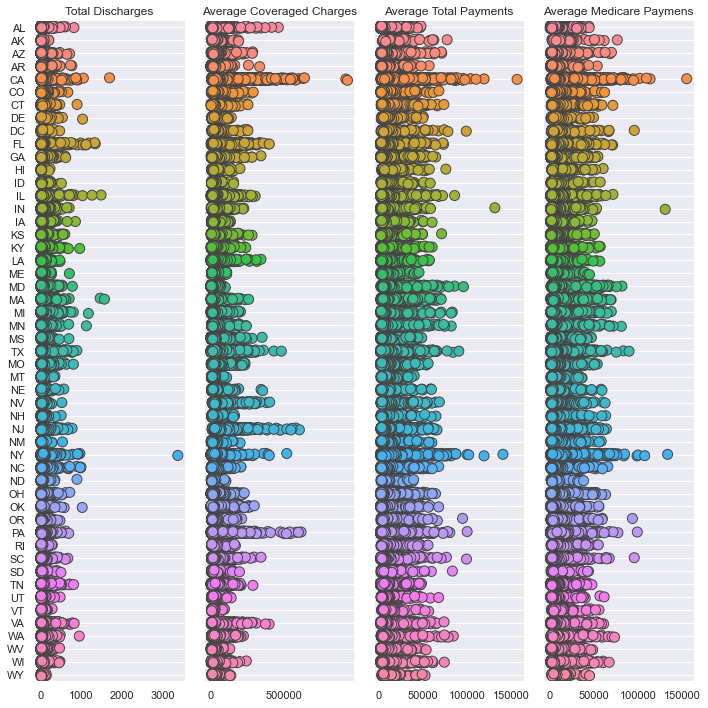

In [13]:
# Make the PairGrid
fig = plt.figure(figsize=(16,10))
g = sns.PairGrid(payment_data,
                 x_vars=['Total Discharges', 'Average Covered Charges', 'Average Total Payments', 'Average Medicare Payments'], 
                 y_vars=["Provider State"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", linewidth=1)

# Use the same x axis limits on all columns and add better labels
g.set(xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Total Discharges", "Average Coveraged Charges", "Average Total Payments",
          "Average Medicare Paymens"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

### Visualization by regions

<Figure size 1152x720 with 0 Axes>

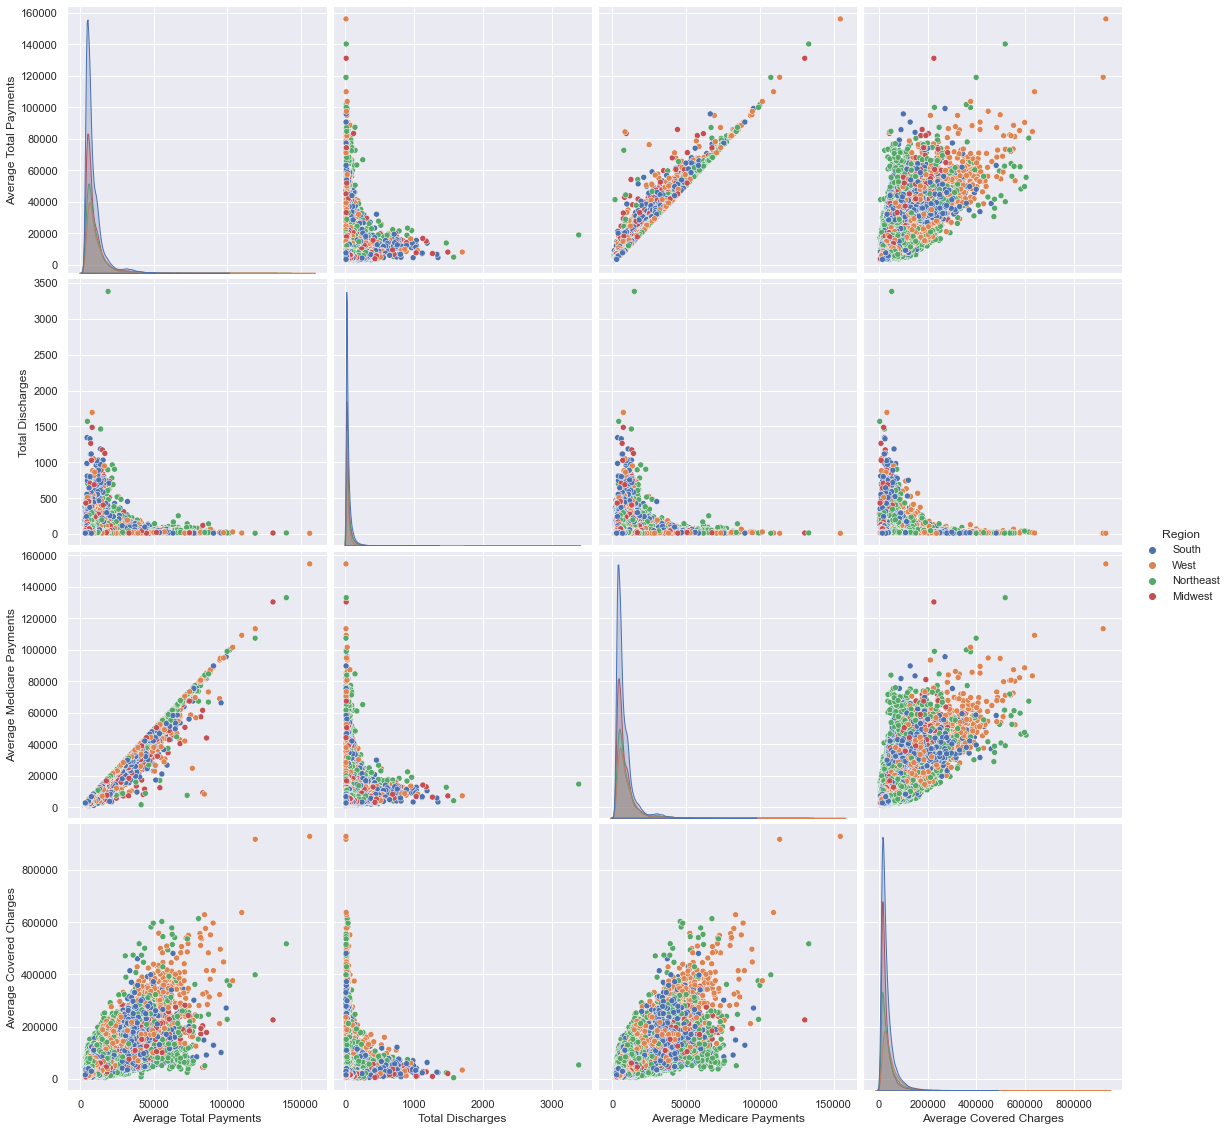

In [14]:
fig = plt.figure(figsize=(16,10))
sns.pairplot(payment_data[['Region','Average Total Payments',
                            'Total Discharges','Average Medicare Payments','Average Covered Charges']], hue= 'Region',height = 4)

### Feature Correlation

In [15]:
stats_df = pd.DataFrame(payment_data, columns=['Average Total Payments',
                            'Total Discharges','Average Medicare Payments','Average Covered Charges'])

<AxesSubplot:>

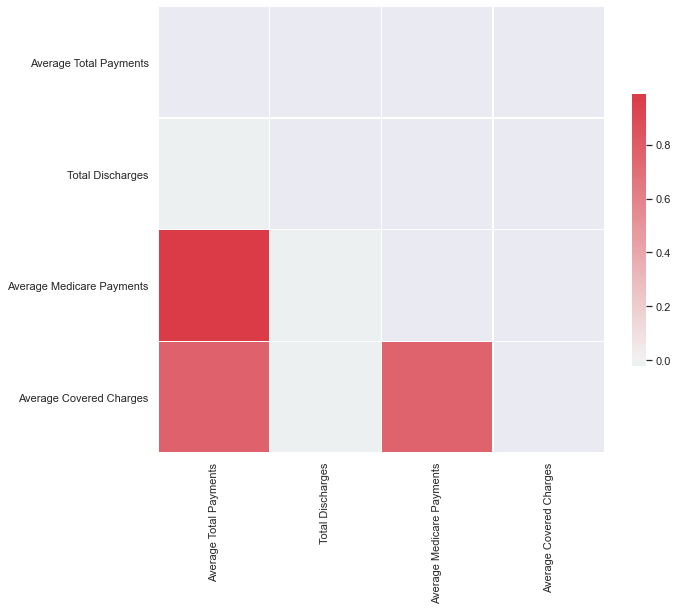

In [16]:
x = stats_df
corr = x.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The average medicare payments and average covered charges are highly correlated to each other. Furthermore, the average medicare payments are also highly correlated with the average total payments.   

### Common Procedures

<AxesSubplot:xlabel='count', ylabel='DRG Definition'>

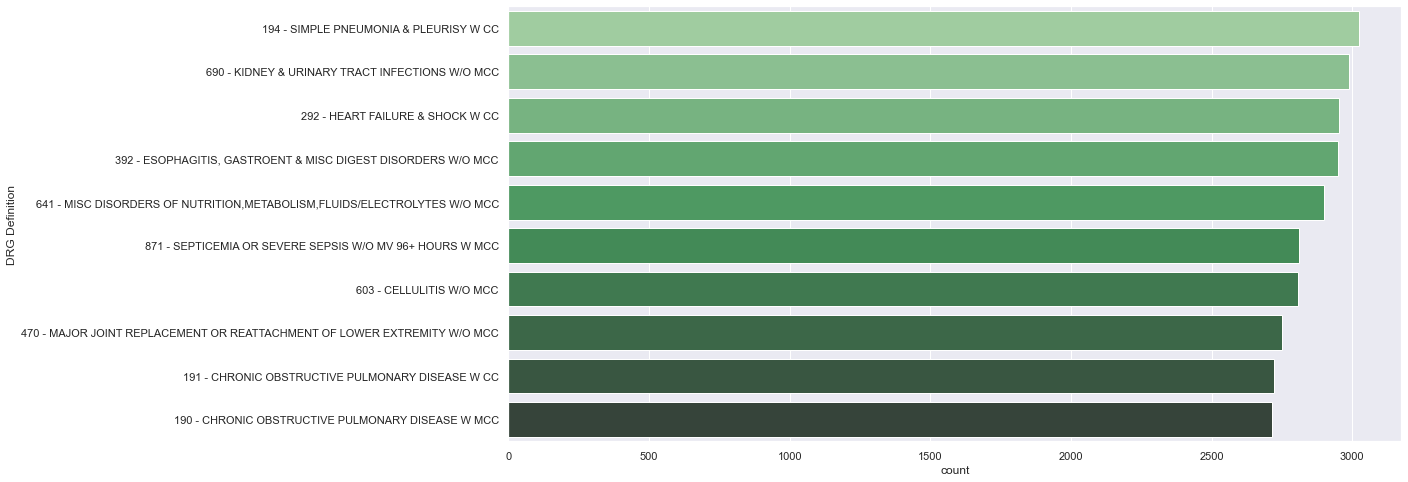

In [17]:
fig = plt.figure(figsize=(16,8))
common_drg = payment_data.groupby('DRG Definition').count()['Provider Id'].sort_values(ascending=False)
top_10 = common_drg[:10]
sns.countplot(y='DRG Definition', data=payment_data, palette="Greens_d",
              order=pd.value_counts(payment_data['DRG Definition']).iloc[:10].index)

### Features Engineering 

#### 1:  Patient Average by Provider ID

This feature will provide an estimation of the average amount charges/payment by each provider.

In [18]:
# gorup by id 
patient_avg_id = payment_data.groupby('Provider Id').mean()[['Total Discharges',
                                    'Average Covered Charges','Average Total Payments','Average Medicare Payments']]
patient_avg_id.head()

Total Discharges  Average Covered Charges  \
Provider Id                                              
10001               58.750000             35247.028152   
10005               28.959184             16451.092041   
10006               45.360465             36942.357442   
10007               27.409091             12079.536818   
10008               17.888889             16148.752222   

             Average Total Payments  Average Medicare Payments  
Provider Id                                                     
10001                   8749.025109                7678.214348  
10005                   6812.131224                5793.631429  
10006                   8197.237907                7145.959535  
10007                   4860.829091                4047.025455  
10008                   5898.136667                4963.547778

**Conclusion**: This feature shows the average charge/payment of each provider which can be used as a baseline when there is any unsual amount. This insight highlights the business use of this feature and shows how it will be helpful with detecting anomalies.

#### 2: Patient Average by State

This feature will provide an estimation of the average amount charges/payment in each state.

In [19]:
patient_avg_state = payment_data.groupby('Provider State').mean()[['Total Discharges',
                                    'Average Covered Charges','Average Total Payments','Average Medicare Payments']]
patient_avg_state.head()

Total Discharges  Average Covered Charges  \
Provider State                                              
AK                     26.588745             40348.743333   
AL                     39.258322             31316.462074   
AR                     41.978229             26174.526246   
AZ                     36.690284             41200.063020   
CA                     36.357854             67508.616536   

                Average Total Payments  Average Medicare Payments  
Provider State                                                     
AK                        14572.391732               12958.969437  
AL                         7568.232149                6418.007120  
AR                         8019.248805                6919.720832  
AZ                        10154.528211                8825.717240  
CA                        12629.668472               11494.381678

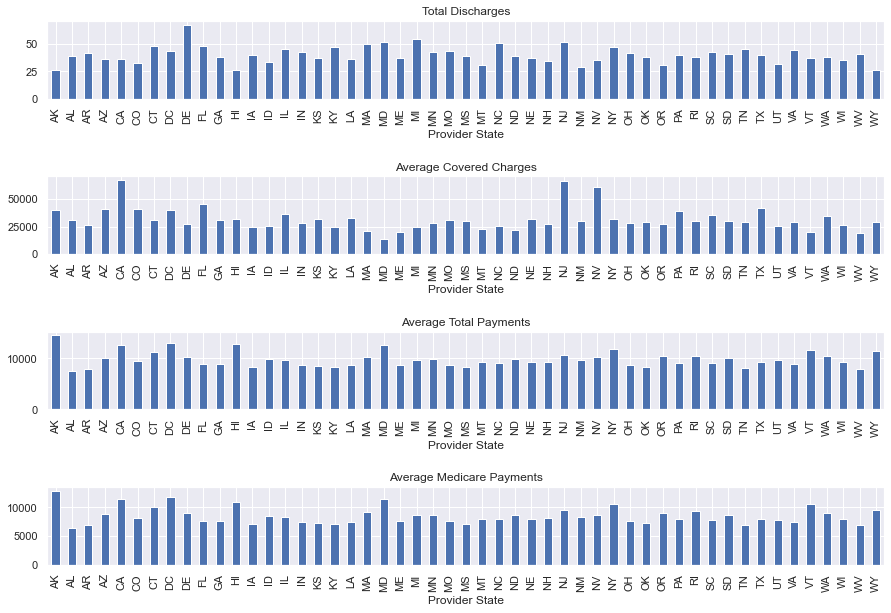

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(15,10))
plt.subplots_adjust(hspace=1)
for i, ax in enumerate(axes.flatten()):
    patient_avg_state[patient_avg_state.columns[i]].plot(kind='bar',ax=ax)
    ax.set_title(patient_avg_state.columns[i])

**Conclusion**: This feature will provide an estimation of the average amount charges/payment in each state which can be used to compare between states and treated as a baseline when there is any unsual amount. This insight highlights the business use of this feature and shows how it will be helpful with detecting anomalies. 

#### 3: Patient Average by Region
This feature displays the average amount charges/payment in each region

In [21]:
patient_avg_reg = payment_data.groupby('Region').mean()[['Total Discharges',
                                    'Average Covered Charges','Average Total Payments','Average Medicare Payments']]

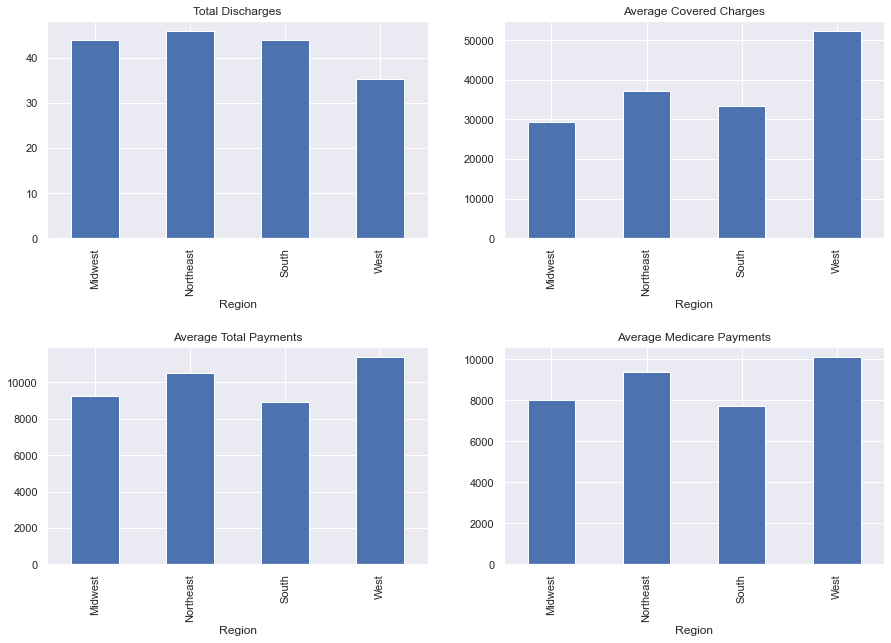

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axes.flatten()):
    patient_avg_reg[patient_avg_reg.columns[i]].plot(kind='bar',ax=ax)
    ax.set_title(patient_avg_reg.columns[i])

**Conclusion**: This feature will provide an estimation of the average amount charges/payment in each region which can be used to compare between them and treated as a baseline when there is any unsual amount in each region. This insight highlights the business use of this feature and shows how it will be helpful with detecting anomalies.

#### 4: Average out of pocket by provider name
This feature is the amount that patient pay by different provider. It gives us an idea which provider has the greatest charges.

In [23]:
payment_data['Ave Out of Pocket Payment'] = payment_data['Average Total Payments'] - payment_data['Average Medicare Payments']

In [24]:
oop_pro= payment_data[['Provider Name', 'Ave Out of Pocket Payment']].groupby(by='Provider Name').agg('mean')
oop_pro = oop_pro.sort_values(('Ave Out of Pocket Payment'), ascending=False)
oop_pro.head()

Ave Out of Pocket Payment
Provider Name                                                    
BAYLOR SURGICAL HOSPITAL AT FORT WORTH               14853.560000
CANCER TREATMENT CENTERS OF AMERICA                   9613.663333
USMD HOSPITAL  AT FORT WORTH LP                       9169.745000
IRVING COPPELL SURGICAL HOSPITAL LLP                  8728.920000
UVA HEALTH SCIENCES CENTER                            8715.730000

Text(0.5, 0, 'Ave OoP per discharge')

<Figure size 2160x1440 with 0 Axes>

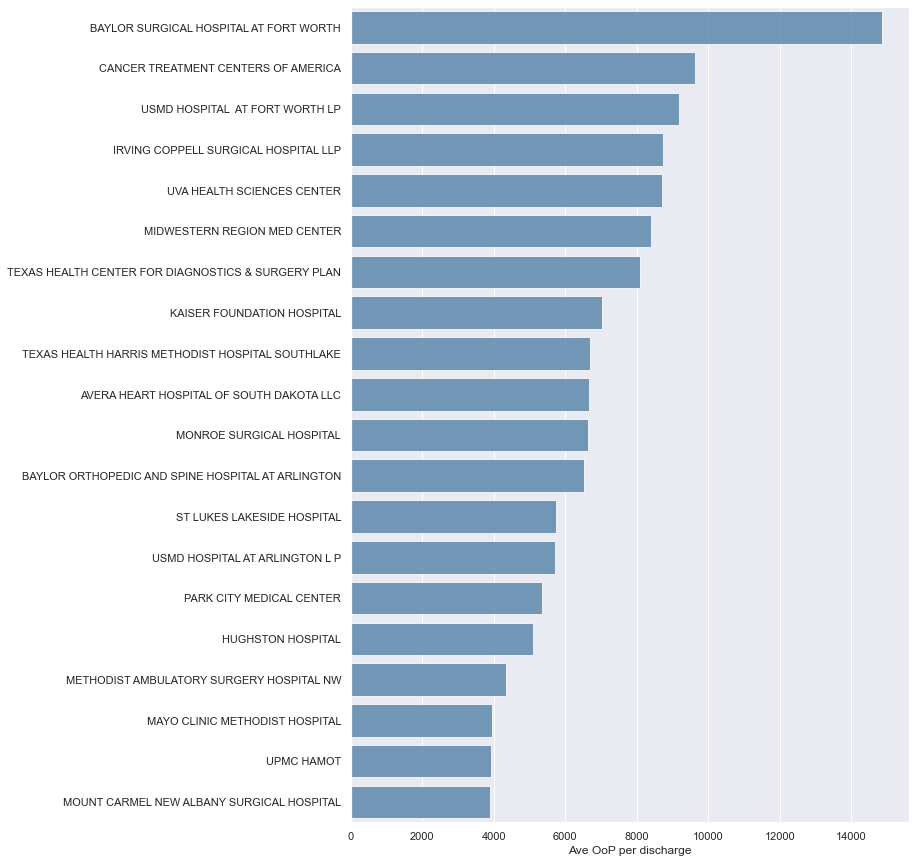

In [25]:
%%capture --no-stdout --no-display output 
#Stop warning from showing

# Top 20 out of pocket per provider

a =  oop_pro[:20]
plt.figure(figsize=(30,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Ave OoP per discharge")

**Conclusion**: Out of pocket is an important indicator for any hospital bill. This feature helps to define the mean of average out of pocket payment in each provider and can be used as a baseline to compare when any out of pocket charges occur.

#### 5: Out of pocket by procedures
This feature is the amount that patient pay by different procedures. It gives us an estimate amount for different procedures

In [26]:
oop_drg= payment_data[['DRG Definition', 'Ave Out of Pocket Payment']].groupby(by='DRG Definition').agg('mean')
oop_drg = oop_drg.sort_values(('Ave Out of Pocket Payment'), ascending=False)
oop_drg.head()

Ave Out of Pocket Payment
DRG Definition                                                               
460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC                       3735.070150
473 - CERVICAL SPINAL FUSION W/O CC/MCC                           2594.714232
247 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT...                2582.521719
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR...                2559.372528
853 - INFECTIOUS & PARASITIC DISEASES W O.R. PR...                2497.221490

Text(0.5, 0, 'Ave OoP by Procedure')

<Figure size 2160x1440 with 0 Axes>

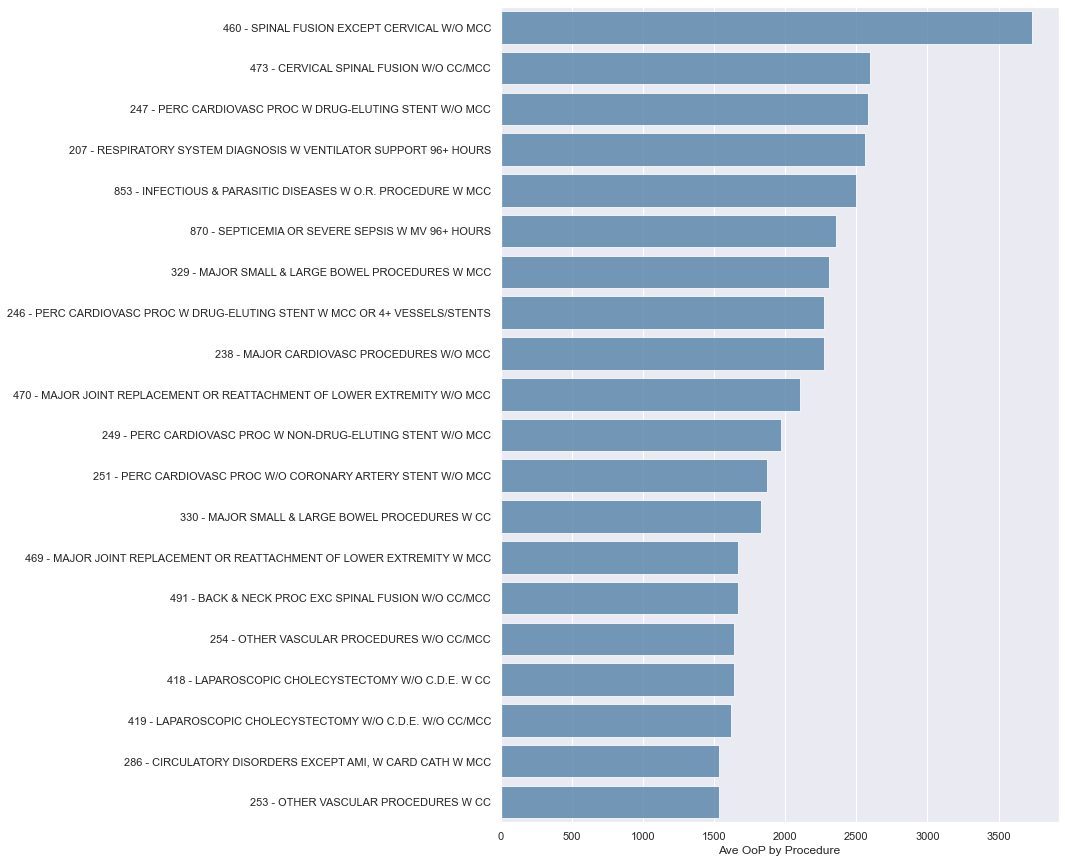

In [27]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

# Top 20 out of pocket by procedure
a =  oop_drg[:20]
plt.figure(figsize=(30,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Ave OoP by Procedure")

**Conclusion**: This feature helps to define the mean of average out of pocket payment in each procedures and can be used as a baseline to detect anomalies.

#### 6: Ave out of pocket per discharge

This feature shows the average amount of out of pocket per discharge for different procedures. If there are a high amount of charge occuring, they would be captured to possibily be investigated if needed.

In [28]:
payment_data['Ave OoP per discharge'] = payment_data['Ave Out of Pocket Payment']/payment_data['Total Discharges']

In [29]:
oop_dis= payment_data[['DRG Definition', 'Ave OoP per discharge']].groupby(by='DRG Definition').agg('mean')
oop_dis = oop_dis.sort_values(('Ave OoP per discharge'), ascending=False)
oop_dis.head()

Ave OoP per discharge
DRG Definition                                                           
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR...             136.913806
460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC                    128.522544
473 - CERVICAL SPINAL FUSION W/O CC/MCC                        126.851226
870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS               121.497520
329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC               113.064950

Text(0.5, 0, 'Ave OoP per discharge')

<Figure size 2160x1440 with 0 Axes>

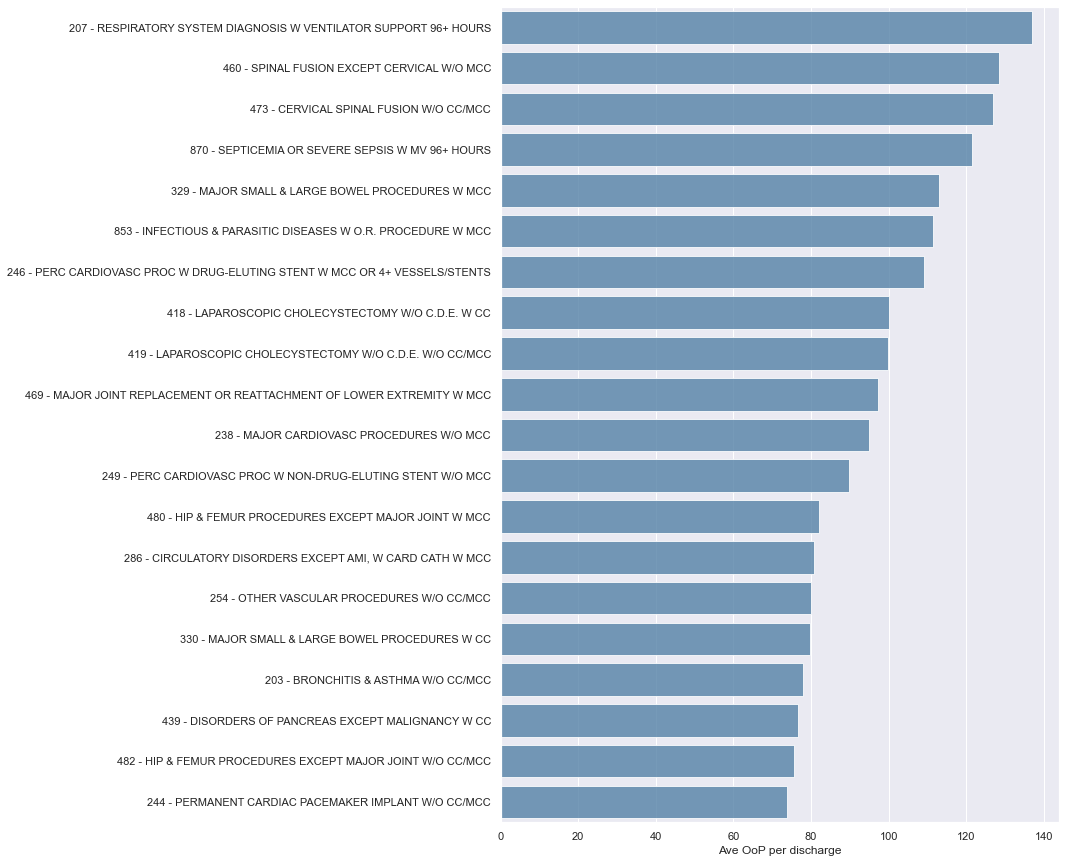

In [30]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

# Top 20 out of pocket per discharge
a =  oop_dis[:20]
plt.figure(figsize=(30,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Ave OoP per discharge")

**Conclusion**: This feature helps to define the mean of average out of pocket payment per discharge for each procedure and can be used as a baseline to detect anomaly. If a discharge pay a big difference amount from the mean for specific procedure, it would be noticable

#### 7: Percent of payment covered
This feature displays the proportion of the total payment compared to covered charge.

In [31]:
payment_data['Percent of Payment Covered'] = round((payment_data['Average Total Payments'] / 
                                                    payment_data['Average Covered Charges'])*100,2)
payment_data['Percent of Payment Covered'].head()

0    17.53
1    38.25
2    14.47
3    38.70
4    17.89
Name: Percent of Payment Covered, dtype: float64

In [32]:
pc_per= payment_data[['DRG Definition', 'Percent of Payment Covered']].groupby(by='DRG Definition').agg('mean')
pc_per = pc_per.sort_values(('Percent of Payment Covered'), ascending=False)
pc_per.head()

Percent of Payment Covered
DRG Definition                                                                
885 - PSYCHOSES                                                      44.798483
603 - CELLULITIS W/O MCC                                             38.141585
897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REHA...                   37.399592
292 - HEART FAILURE & SHOCK W CC                                     37.206478
871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HO...                   37.103869

Text(0.5, 0, 'Percent of Payment Covered')

<Figure size 2160x1440 with 0 Axes>

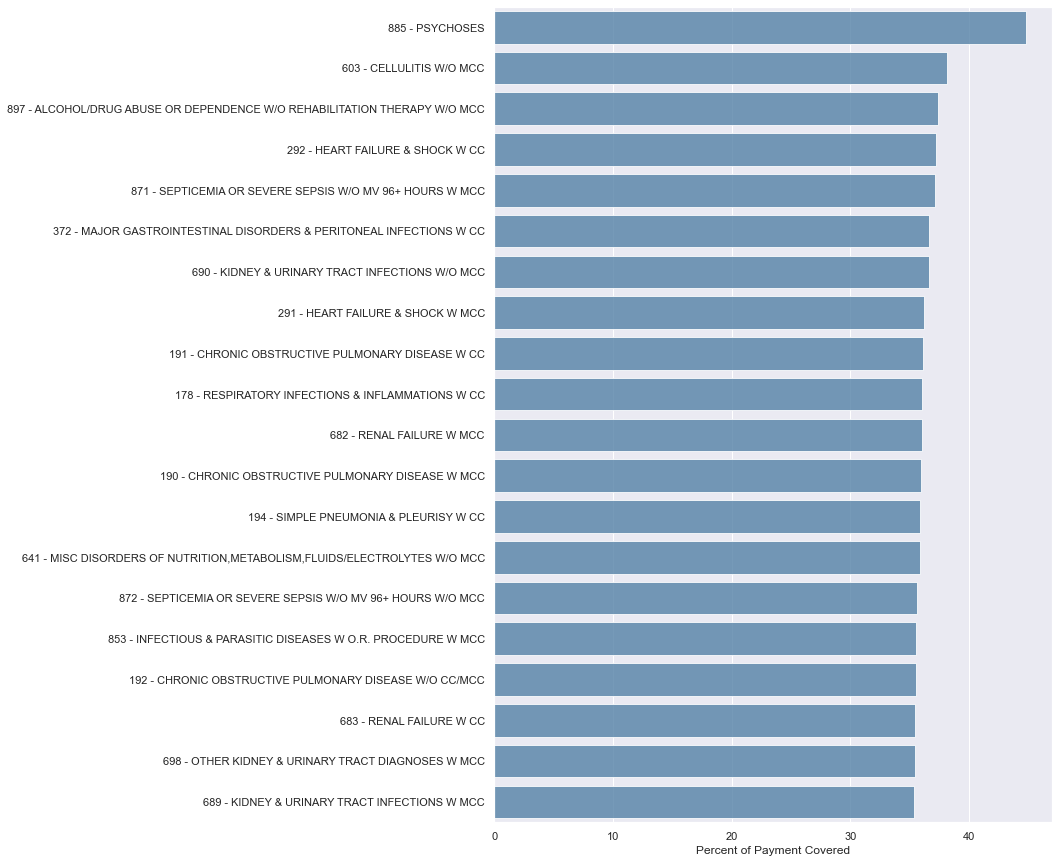

In [33]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

# Top 20 highest percent of payment covered
a =  pc_per[:20]
plt.figure(figsize=(30,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Percent of Payment Covered")

**Conclusion**: This feature helps to define the percent of payment covered and can be used as a baseline to detect anomaly. If an unsual percentage of payment for a procedure occurs, it would be noticable.

#### 8: Medicare coverage ratio

This feature calculates the proportion covered by medicare for different procedures

In [34]:
payment_data['Medicare Coverage Ratio'] = (payment_data['Average Medicare Payments'] / payment_data['Average Total Payments'])

In [35]:
med_cv = payment_data[['DRG Definition', 'Medicare Coverage Ratio']].groupby(by='DRG Definition').agg('mean')
med_cv = med_cv.sort_values(('Medicare Coverage Ratio'), ascending=True)
med_cv.head()

Medicare Coverage Ratio
DRG Definition                                                             
310 - CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS...                 0.717772
203 - BRONCHITIS & ASTHMA W/O CC/MCC                               0.719805
313 - CHEST PAIN                                                   0.727650
390 - G.I. OBSTRUCTION W/O CC/MCC                                  0.732743
149 - DYSEQUILIBRIUM                                               0.742108

Text(0.5, 0, 'Medicare Coverage Ratio')

<Figure size 1440x1440 with 0 Axes>

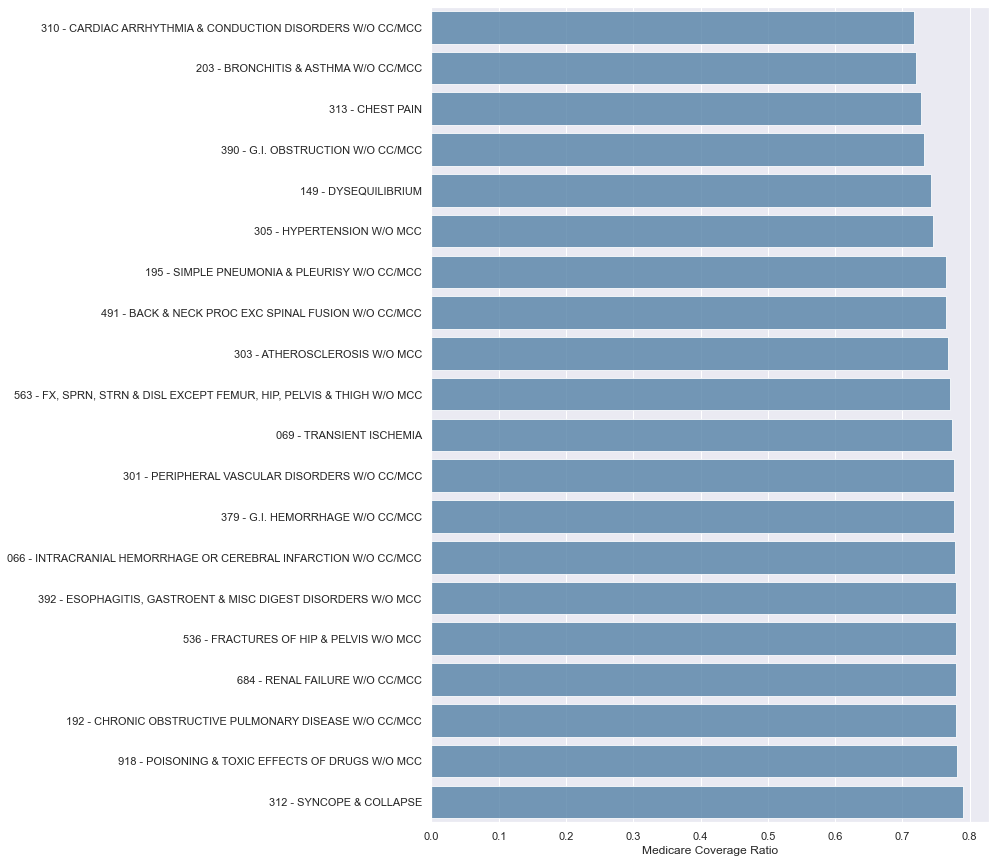

In [36]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

# Top 20 highest medicare covered
a =  med_cv[:20]
plt.figure(figsize=(20,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Medicare Coverage Ratio")

**Conclusion**: This feature helps to define the percent of medicare coverage for each procedure and can be used as a baseline to detect anomaly. If an unsual percentage of medicare charges for a procedure occurs, it would be noticable.

#### 9: Medicare coverage ratio by state
This feature displays the average percentage covered by medicare in each state

In [37]:
med_cv_state = payment_data[['Provider State', 'Medicare Coverage Ratio']].groupby(by='Provider State').agg('mean')
med_cv_state = med_cv_state.sort_values(('Medicare Coverage Ratio'), ascending=False)
med_cv_state.head()

Medicare Coverage Ratio
Provider State                         
MD                             0.888943
CA                             0.885084
DC                             0.884320
VT                             0.874861
MA                             0.872525

Text(0.5, 0, 'Medicare Coverage Ratio')

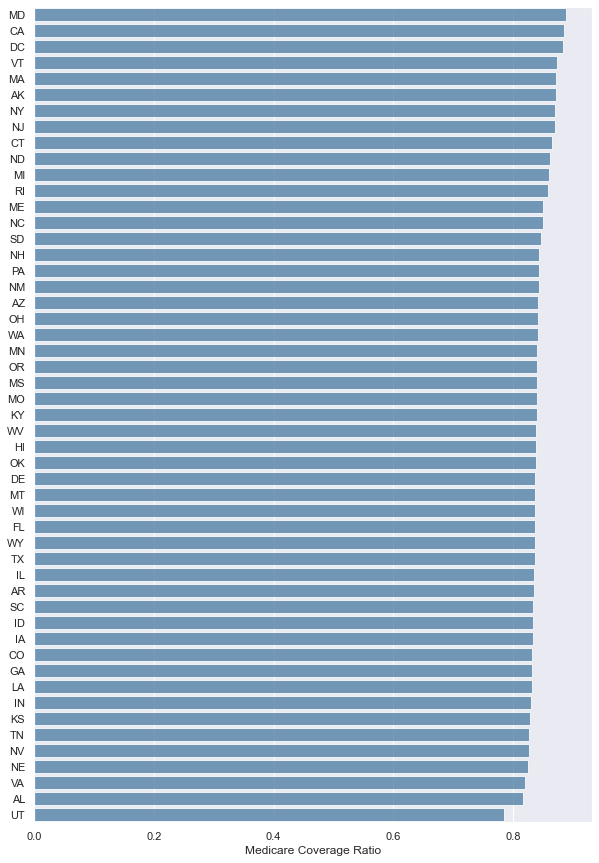

In [38]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

fig,ax= plt.subplots()
fig = sns.barplot(med_cv_state.iloc[:,0],med_cv_state.index,color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Medicare Coverage Ratio")

**Conclusion**: This feature helps to define the percent of medicare coverage in each state and can be used as a baseline to detect anomalies. If an unsual percentage of medicare happens, it would be noticable

###  Z-score 
Z-scores can quantify the unusualness of an observation when your data follow the normal distribution. Z-scores are the number of standard deviations above and below the mean that each value falls. For example, a Z-score of 2 indicates that an observation is two standard deviations above the average while a Z-score of -2 signifies it is two standard deviations below the mean. A Z-score of zero represents a value that equals the mean.

An absolute Z-score greater than 3 are an outlier/anomaly as they fall outside 99.7% of the data.


#### 10: Z-score Average Total Payment 
This feature calculates the z-score for average total payment

In [39]:
payment_data['Z-score Average Total Payments'] = stats.zscore(payment_data['Average Total Payments'])

In [40]:
payment_data['Z-score Average Total Payments'].max()

19.10736911457284

**Conclusion**: An absolute Z-score greater than 3 are an outlier/anomaly as they fall outside 99.7% of the data.This feature helps to detect any outlier in total payments. The example above shows that there is a z-score of 19.10 in the average total payment which needs to be investigated.

#### 11: Z-score Average Medicare Payments	
This feature calculates the z-score for average medicare payment

In [41]:
payment_data['Z-score Average Medicare Payments'] = stats.zscore(payment_data['Average Medicare Payments'])

In [42]:
payment_data['Z-score Average Medicare Payments'].max()

19.99143875873488

**Conclusion**: An absolute Z-score greater than 3 are an outlier/anomaly as they fall outside 99.7% of the data.This feature helps to detect any outlier in medicare payments. The example above shows that there is a z-score of 19.99 in the average medicare payment which need to be investigated.

#### 12: Average Covered Charges by Procedures
This feature calculates the average cost and number of cases of each procedure

In [43]:
ave_cv = payment_data[['DRG Definition', 'Average Covered Charges']].groupby(by='DRG Definition').agg(['mean','count'])
ave_cv = ave_cv.sort_values(('Average Covered Charges',  'mean'), ascending=False)
ave_cv.head()

Average Covered Charges  \
                                                                      mean   
DRG Definition                                                               
870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS             163227.331725   
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR...           143428.051066   
853 - INFECTIOUS & PARASITIC DISEASES W O.R. PR...           139186.350937   
329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC             135330.939966   
246 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT...            96348.806707   

                                                          
                                                   count  
DRG Definition                                            
870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS     939  
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR...  1163  
853 - INFECTIOUS & PARASITIC DISEASES W O.R. PR...  1376  
329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC    1476  
246 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT...   917

In [44]:
# Top 10 highest Average Medicare Payments
a = ave_cv[:10]

<Figure size 1080x1080 with 0 Axes>

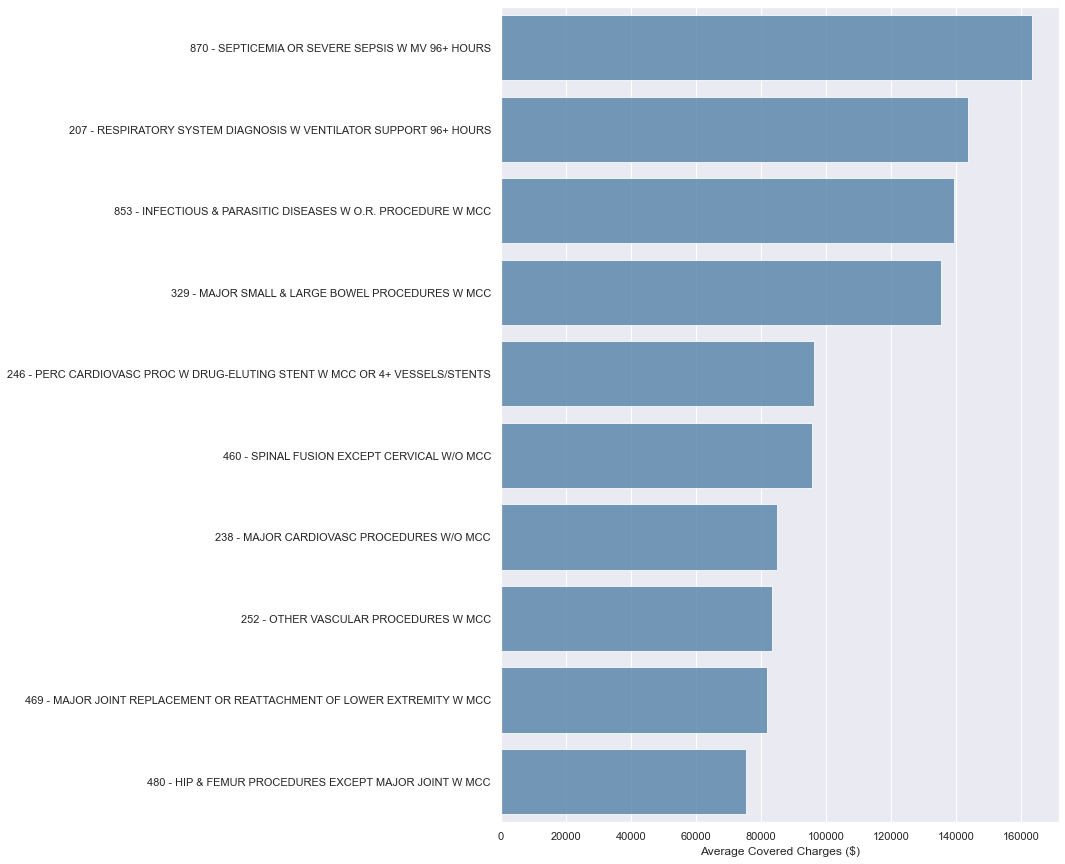

<Figure size 1080x1080 with 0 Axes>

In [45]:
%%capture --no-stdout --no-display output
# prevent warning message from showing
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Average Covered Charges ($)")
plt.figure(figsize=(15,15))

**Conclusion**: This features provides the insights of hospital bill for different procedures. From that, we could detect any unsual charge for specific procedure.

#### 12: Common Procedures by Region
This feature calculates the total cases of all procedures in each region

In [46]:
common_drug =  payment_data[['Region', 'DRG Definition']].groupby(by=['Region','DRG Definition']).agg({'DRG Definition': 'count'})

In [47]:
common_drug[:20]

DRG Definition
Region  DRG Definition                                                    
Midwest 039 - EXTRACRANIAL PROCEDURES W/O CC/MCC                       295
        057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O...             292
        064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR...             396
        065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR...             548
        066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR...             438
        069 - TRANSIENT ISCHEMIA                                       468
        074 - CRANIAL & PERIPHERAL NERVE DISORDERS W/O MCC             245
        101 - SEIZURES W/O MCC                                         374
        149 - DYSEQUILIBRIUM                                           273
        176 - PULMONARY EMBOLISM W/O MCC                               373
        177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W MCC             443
        178 - RESPIRATORY INFECTIONS & INFLAMMATIONS W CC              453
        189 - PULMONARY EDEMA & RESPIRATORY FAILURE                    515
        190 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC              637
        191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC               643
        192 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W/O...             621
        193 - SIMPLE PNEUMONIA & PLEURISY W MCC                        618
        194 - SIMPLE PNEUMONIA & PLEURISY W CC                         711
        195 - SIMPLE PNEUMONIA & PLEURISY W/O CC/MCC                   605
        202 - BRONCHITIS & ASTHMA W CC/MCC                             298

**Conclusion**: This feature can be used to identify non-common procedures and common procedures in each region, thus giving us an idea of what procedures are most common in each region. Therefore, we would be able to take closer look to different price point by provider for common procedures and  non-common procedures in order to detect fraud.

#### 13: Differences in Average Total Payment
This feature is the differences between maximum and minimum payments for each procedure

In [48]:
differences = payment_data[['DRG Definition','Average Total Payments']].groupby(by='DRG Definition').agg(['max','min'])
differences['Difference'] = differences[('Average Total Payments','max')] - differences[('Average Total Payments','min')]
differences = differences[:20].sort_values(by='Difference',ascending=False)
# the results were limited to the first 20 values, but can be changed to include as many or as little as needed by adjusting the range

<Figure size 1080x1080 with 0 Axes>

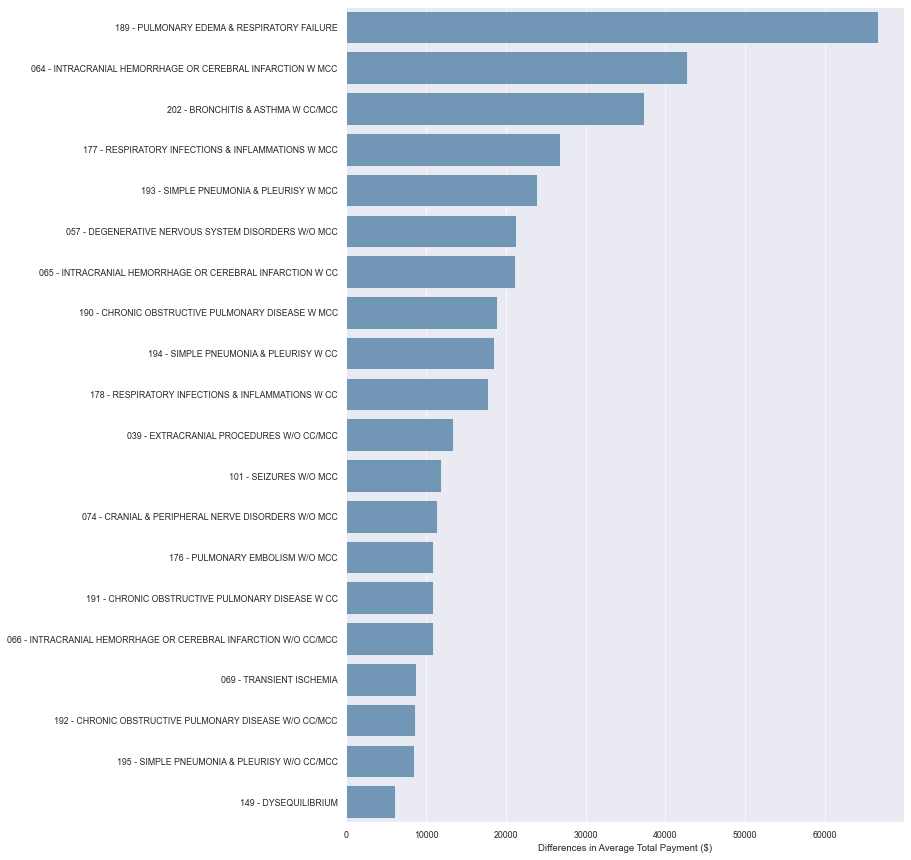

<Figure size 1080x1080 with 0 Axes>

In [49]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

sns.set_context("paper")
ax = sns.barplot(differences["Difference"],differences.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Differences in Average Total Payment ($)")
plt.figure(figsize=(15,15))

**Conclusion**: This feature helps to identify the difference in payment for the same procedure. If the difference is high for a procedure, it means that the payment varies largely between different states or different providers. Thus, we need to investigate further for these procedures. 

## Part 2: Data Preparation <a class="anchor" id="Part_2"></a>
In this part, I use K-means clustering algorithm to explore the dataset, following the steps below:

    - Drop irrelevant variables
    - Standardization of Numerical / Float variables

#### Payment data contains 19 mixed features of numerical and categorical columns. 

In [50]:
payment_data = payment_data.drop(columns = ['Provider Id'])

In [51]:
features = payment_data

In [52]:
%%capture --no-stdout --no-display output
features = features.merge(differences, on = "DRG Definition", how = "left")

In [53]:
# dtop Ave max and min here and keep difference
features.head()

DRG Definition                     Provider Name  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  SOUTHEAST ALABAMA MEDICAL CENTER   
1  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC     MARSHALL MEDICAL CENTER SOUTH   
2  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    ELIZA COFFEE MEMORIAL HOSPITAL   
3  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC                 ST VINCENT'S EAST   
4  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC     SHELBY BAPTIST MEDICAL CENTER   

      Provider Street Address Provider City Provider State Provider Zip Code  \
0      1108 ROSS CLARK CIRCLE        DOTHAN             AL             36301   
1  2505 U S HIGHWAY 431 NORTH          BOAZ             AL             35957   
2          205 MARENGO STREET      FLORENCE             AL             35631   
3  50 MEDICAL PARK EAST DRIVE    BIRMINGHAM             AL             35235   
4     1000 FIRST STREET NORTH     ALABASTER             AL             35007   

  Hospital Referral Region Description  Total Discharges  \
0                          AL - Dothan                91   
1                      AL - Birmingham                14   
2                      AL - Birmingham                24   
3                      AL - Birmingham                25   
4                      AL - Birmingham                18   

   Average Covered Charges  Average Total Payments  ...  Region  \
0                 32963.07                 5777.24  ...   South   
1                 15131.85                 5787.57  ...   South   
2                 37560.37                 5434.95  ...   South   
3                 13998.28                 5417.56  ...   South   
4                 31633.27                 5658.33  ...   South   

  Ave Out of Pocket Payment  Ave OoP per discharge  \
0                   1013.51              11.137473   
1                    810.86              57.918571   
2                    981.16              40.881667   
3                   1288.40              51.536000   
4                    806.89              44.827222   

   Percent of Payment Covered  Medicare Coverage Ratio  \
0                       17.53                 0.824568   
1                       38.25                 0.859896   
2                       14.47                 0.819472   
3                       38.70                 0.762181   
4                       17.89                 0.857398   

   Z-score Average Total Payments  Z-score Average Medicare Payments  \
0                       -0.512776                          -0.510403   
1                       -0.511428                          -0.481265   
2                       -0.557435                          -0.552805   
3                       -0.559703                          -0.597218   
4                       -0.528290                          -0.498403   

   (Average Total Payments, max)  (Average Total Payments, min)  \
0                       18420.56                         4968.0   
1                       18420.56                         4968.0   
2                       18420.56                         4968.0   
3                       18420.56                         4968.0   
4                       18420.56                         4968.0   

   (Difference, )  
0        13452.56  
1        13452.56  
2        13452.56  
3        13452.56  
4        13452.56  

[5 rows x 21 columns]

In [54]:
features.rename(columns={('Average Total Payments', 'max'):'max',
                         ('Average Total Payments', 'min'): 'min',
                         ('Difference', ''): 'Differences'
                        }, inplace=True)

In [55]:
features.drop(
    ['min', 'max'],
    axis=1, inplace=True)

In [56]:
# not doing this one because the df only has the medicare coverage ratio columns, this one provides information 
## of coverage ratio by state.
features = features.merge(med_cv_state, on = "Provider State", how = "left")

In [57]:
features = features.merge(patient_avg_state, on = "Provider State", how= "left")

In [58]:
# Rename the last 4 columns as Ave by state
features.head()

DRG Definition                     Provider Name  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  SOUTHEAST ALABAMA MEDICAL CENTER   
1  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC     MARSHALL MEDICAL CENTER SOUTH   
2  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    ELIZA COFFEE MEMORIAL HOSPITAL   
3  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC                 ST VINCENT'S EAST   
4  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC     SHELBY BAPTIST MEDICAL CENTER   

      Provider Street Address Provider City Provider State Provider Zip Code  \
0      1108 ROSS CLARK CIRCLE        DOTHAN             AL             36301   
1  2505 U S HIGHWAY 431 NORTH          BOAZ             AL             35957   
2          205 MARENGO STREET      FLORENCE             AL             35631   
3  50 MEDICAL PARK EAST DRIVE    BIRMINGHAM             AL             35235   
4     1000 FIRST STREET NORTH     ALABASTER             AL             35007   

  Hospital Referral Region Description  Total Discharges_x  \
0                          AL - Dothan                  91   
1                      AL - Birmingham                  14   
2                      AL - Birmingham                  24   
3                      AL - Birmingham                  25   
4                      AL - Birmingham                  18   

   Average Covered Charges_x  Average Total Payments_x  ...  \
0                   32963.07                   5777.24  ...   
1                   15131.85                   5787.57  ...   
2                   37560.37                   5434.95  ...   
3                   13998.28                   5417.56  ...   
4                   31633.27                   5658.33  ...   

   Percent of Payment Covered Medicare Coverage Ratio_x  \
0                       17.53                  0.824568   
1                       38.25                  0.859896   
2                       14.47                  0.819472   
3                       38.70                  0.762181   
4                       17.89                  0.857398   

   Z-score Average Total Payments  Z-score Average Medicare Payments  \
0                       -0.512776                          -0.510403   
1                       -0.511428                          -0.481265   
2                       -0.557435                          -0.552805   
3                       -0.559703                          -0.597218   
4                       -0.528290                          -0.498403   

   Differences  Medicare Coverage Ratio_y  Total Discharges_y  \
0     13452.56                   0.816622           39.258322   
1     13452.56                   0.816622           39.258322   
2     13452.56                   0.816622           39.258322   
3     13452.56                   0.816622           39.258322   
4     13452.56                   0.816622           39.258322   

   Average Covered Charges_y  Average Total Payments_y  \
0               31316.462074               7568.232149   
1               31316.462074               7568.232149   
2               31316.462074               7568.232149   
3               31316.462074               7568.232149   
4               31316.462074               7568.232149   

   Average Medicare Payments_y  
0                   6418.00712  
1                   6418.00712  
2                   6418.00712  
3                   6418.00712  
4                   6418.00712  

[5 rows x 24 columns]

In [59]:
features = features.rename(columns={"Total Discharges_x": "Total_Discharges", 
                                   "Average Covered Charges_x": "Ave_Covered_Charges",
                                   "Average Total Payments_x": "Ave_Total_Payments",
                                   "Average Medicare Payments_x":"Aver_Medicare_Payments",
                                   "Ave Out of Pocket Payment":"Ave_OOP",
                                   "Percent of Payment Covered" : "Prop_payment_covered",
                                   "Medicare Coverage Ratio_x":"Medicare_Coverage_Ratio",
                                   "Z-score Average Total Payments": "Zscore_ave_total_payment",
                                   "Z-score Average Medicare Payments": "Zscore_ave_medicare_payment",
                                    "Medicare Coverage Ratio_y": "Medicare_coverage_ratio_bystate",
                                   "Total Discharges_y":"Mean_Total_Discharge_bystate", 
                                   "Average Covered Charges_y":"Mean_Ave_Covered_bystate",
                                  "Average Total Payments_y":"Mean_Ave_Total_Payment_bystate",
                                  "Average Medicare Payments_y":"Mean_Ave_Medicare_bystate"})

#### *Note*
K-means only works with numerical columns and there are more than 50 unique values in categorical columns like DRG definition, Provider ID, provider name, provider city, provider state, provider zipcode, hospital referral regions. Therefore, one hot encoder doesn't make significant support to clustering method. Additionally, using one hot encoding creates many different new binary features which does not apply to K-mean clustering accurately.  Therefore, all categorical columns are decided to drop.

In [60]:
categorical_col = features.loc[:, features.dtypes == np.object]
a = categorical_col.columns
features = features.drop(columns = a)

In [61]:
features.columns

Index(['Total_Discharges', 'Ave_Covered_Charges', 'Ave_Total_Payments',
       'Aver_Medicare_Payments', 'Ave_OOP', 'Ave OoP per discharge',
       'Prop_payment_covered', 'Medicare_Coverage_Ratio',
       'Zscore_ave_total_payment', 'Zscore_ave_medicare_payment',
       'Differences', 'Medicare_coverage_ratio_bystate',
       'Mean_Total_Discharge_bystate', 'Mean_Ave_Covered_bystate',
       'Mean_Ave_Total_Payment_bystate', 'Mean_Ave_Medicare_bystate'],
      dtype='object')

In [62]:
features.isnull().sum()

Total_Discharges                        0
Ave_Covered_Charges                     0
Ave_Total_Payments                      0
Aver_Medicare_Payments                  0
Ave_OOP                                 0
Ave OoP per discharge                   0
Prop_payment_covered                    0
Medicare_Coverage_Ratio                 0
Zscore_ave_total_payment                0
Zscore_ave_medicare_payment             0
Differences                        124528
Medicare_coverage_ratio_bystate         0
Mean_Total_Discharge_bystate            0
Mean_Ave_Covered_bystate                0
Mean_Ave_Total_Payment_bystate          0
Mean_Ave_Medicare_bystate               0
dtype: int64

With a large amount of missing values in differences column, it does not have significant impact to the model after imputing missing values

In [63]:
features['Differences'].isnull().sum()/len(features)

0.7636709287707356

In [64]:
features = features.drop(columns = ['Differences'])

### Correlation

<AxesSubplot:>

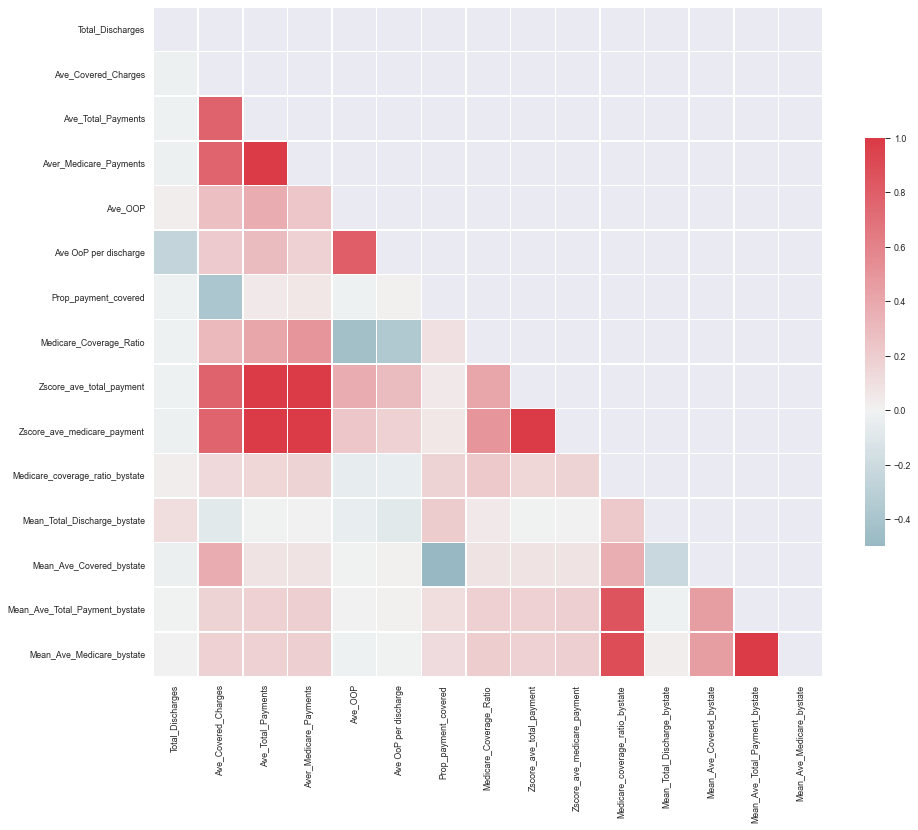

In [65]:
corr = features.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In general, feautures that are too correlated do not improve model efficiency and also affect the performance of linear regression and random forest models, making the learning algorithms slower to create and train. Therefore, I removed highly correlated features to prevent multicollinearity trhough the following function:

In [66]:
# Function to remove columns with high correlation value
def correlation(dataset, threshold):
    """
    Remove columns that do exceeed correlation threshold
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

In [67]:
features = correlation(features, 0.8)

In [68]:
features.columns

Index(['Total_Discharges', 'Ave_Covered_Charges', 'Ave_Total_Payments',
       'Ave_OOP', 'Ave OoP per discharge', 'Prop_payment_covered',
       'Medicare_Coverage_Ratio', 'Medicare_coverage_ratio_bystate',
       'Mean_Total_Discharge_bystate', 'Mean_Ave_Covered_bystate'],
      dtype='object')

As total discharges amount varies depending on the hospital location, size, treatement provided. This feature would not support the model performance and might affect the accuracy of the model. Thus, I will drop both of the discharges features before further analysis. 

In [69]:
features = features.drop(columns = ['Total_Discharges','Mean_Total_Discharge_bystate'])

#### Splitting train and test dataset

In [70]:
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
X_train, X_test = tts(features, test_size=0.30)

#### Standardize data

In [71]:
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

## Part 3: Unsupervised Learning for Anomalies Detection <a class="anchor" id="Part_3"></a>

In this part. I will use autoencoder and isolation forest algorithm to detect outliers. I will try 3 different models, the average and the maximun of maximun methods for both of the approaches. Furthermore, the feature selection plays an important role to the success of a model, beside their statistical support, it is important to understand their business insights and how they would affect the model. Below is a briefly explaination of the selected features and why they are important: 

   - **Ave_Covered_Charges**: The average charge of all provider's services covered by Medicare for discharges in the DRG, providng the differences in coverage by different hospital charge structures.
   - **Ave_Total_Payments**: The average total payments to all providers for the DRG, providing the difference of total payments by different providers for the drug. 
   - **Ave_OOP**: The average out of pocket payment by different provider, providing an idea of the cost by different providers. This feature helps to define the mean of average out of pocket payment in each provider and can be used as a baseline to compare when any out of pocket charges occur.
   - **Ave OoP per discharge**: This feature helps to define the mean of average out of pocket payment per discharge for each procedure and can be used as a baseline to detect anomaly. If a discharge pay a big difference amount from the mean for specific procedure, it would be noticable.
   - **Prop_payment_covered**: This feature displays the proportion of the total payment compared to covered charge.If an unsual percentage of payment for a procedure occurs, it would be noticable. If an unsual percentage of payment for a procedure occurs, it would be noticable.
   - **Medicare_Coverage_Ratio**: This feature represents the proportion covered by medicare for different procedures and can be used as a baseline to detect anomaly. If an unsual percentage of medicare charges for a procedure occurs, it would be noticable.
   - **Medicare_coverage_ratio_bystate**: This feature displays the average percentage covered by medicare in each state and can be used as a baseline to detect anomalies. If an unsual percentage of medicare happens, it would be noticable.
   - **Mean_Ave_Covered_bystate**: This feature will provide an estimation of the average covered charge in each state which can be used to compare between states and treated as a baseline when there is any unsual amount within a state.

### Autoencoder

Autoencoder techniques can perform non-linear transformations with their non-linear activation function and multiple layers.It is more efficient to train several layers with an autoencoder, rather than training one huge transformation with PCA.

Autoencoder is an unsupervised learning of artificial neural network that copies the input values (input layer) to the output values (output layer) throughout many hidden layers. The hidden layers in an autoencoder model must have fewers dimensions that those of the input or outpu layers. If the number of neurons is more than the input and output layers, the model will be given too much capacity to learn the data and simply return the output values as the input values, without extracting any essential information.

#### Model 1

In [72]:
from pyod.models.auto_encoder import AutoEncoder

In [73]:
#from pyod.models.auto_encoder import AutoEncoder
clf1 = AutoEncoder(hidden_neurons =[9, 2, 2, 9])
clf1.fit(X_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 81        
_________________________________________________________________
dropout_2 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2

Epoch 59/100
3211/3211 [==============================] - 3s 858us/step - loss: 1.0066 - val_loss: 0.9410
Epoch 60/100
3211/3211 [==============================] - 3s 878us/step - loss: 1.0066 - val_loss: 0.9410
Epoch 61/100
3211/3211 [==============================] - 3s 902us/step - loss: 1.0066 - val_loss: 0.9410
Epoch 62/100
3211/3211 [==============================] - 3s 903us/step - loss: 1.0066 - val_loss: 0.9410
Epoch 63/100
3211/3211 [==============================] - 3s 966us/step - loss: 1.0066 - val_loss: 0.9410
Epoch 64/100
3211/3211 [==============================] - 3s 860us/step - loss: 1.0066 - val_loss: 0.9410
Epoch 65/100
3211/3211 [==============================] - 3s 863us/step - loss: 1.0066 - val_loss: 0.9410
Epoch 66/100
3211/3211 [==============================] - 3s 929us/step - loss: 1.0066 - val_loss: 0.9410
Epoch 67/100
3211/3211 [==============================] - 3s 905us/step - loss: 1.0066 - val_loss: 0.9410
Epoch 68/100
3211/3211 [======================

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[9, 2, 2, 9],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x000002632C152598>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

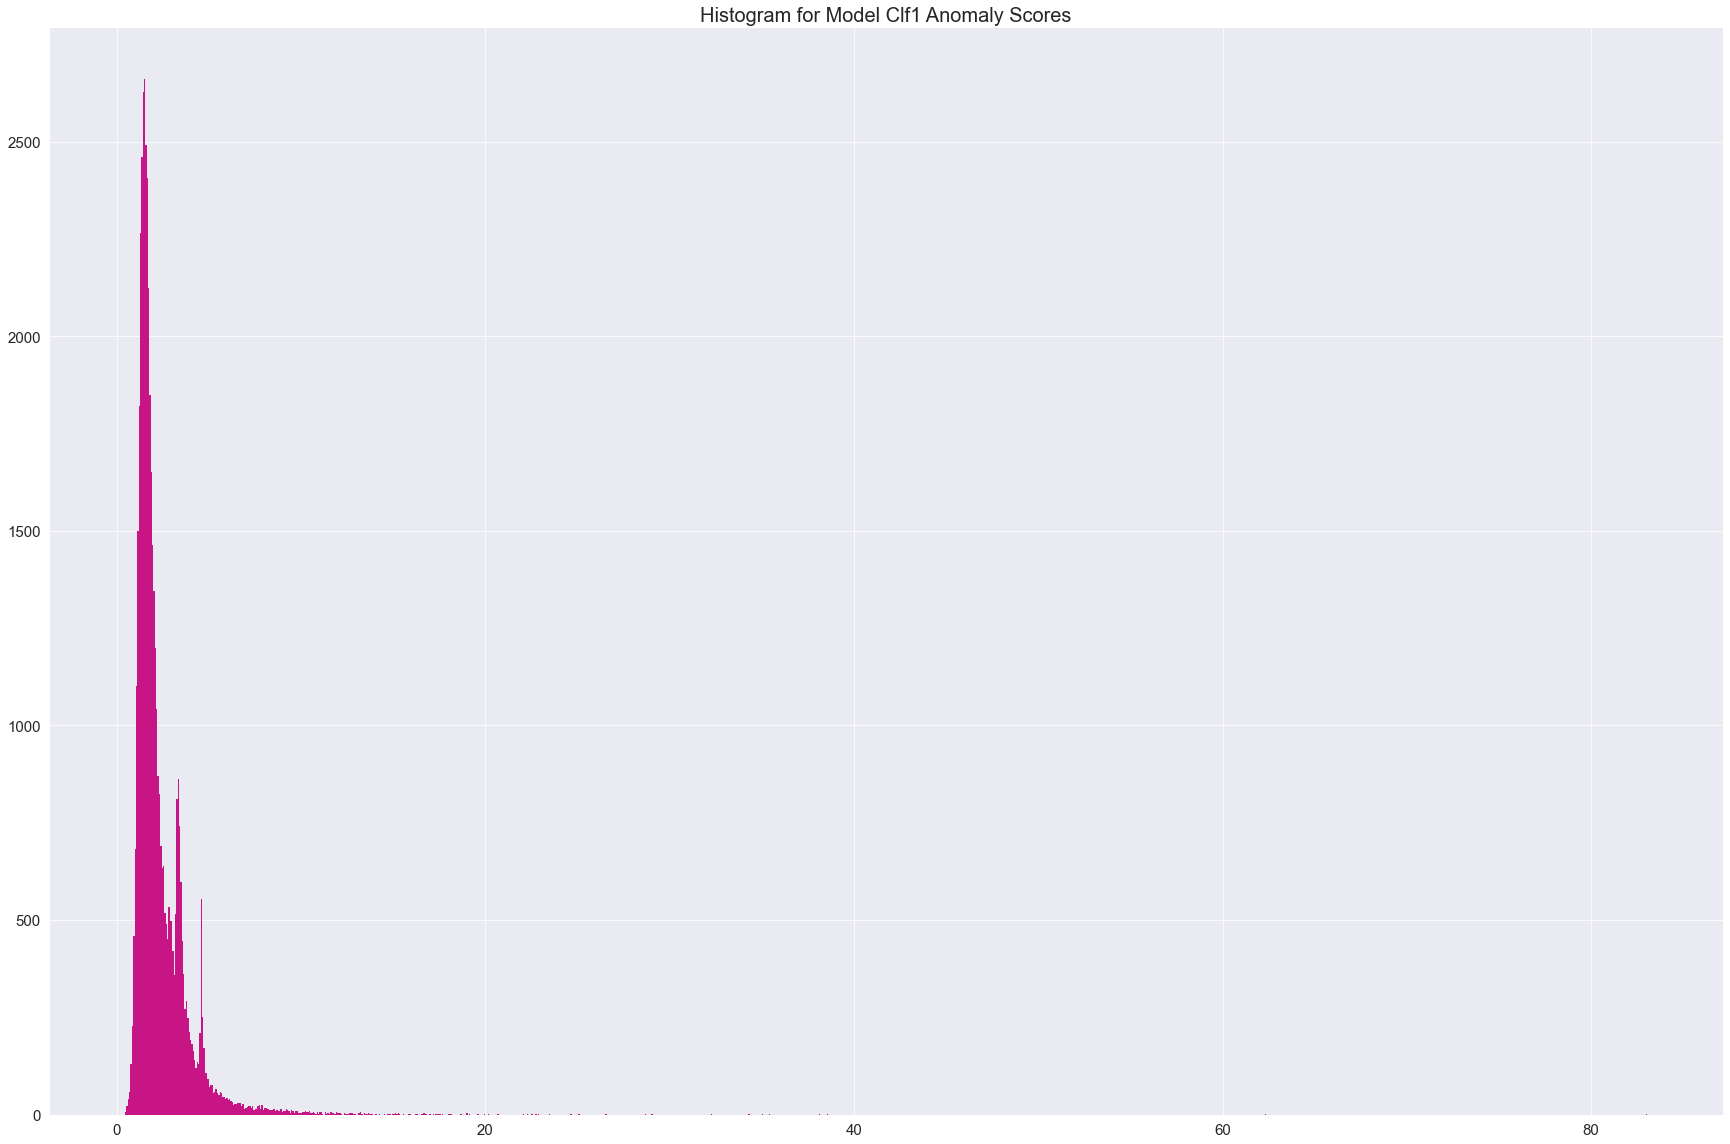

In [74]:
# Get the outlier scores for the train data
y_train_scores_1 = clf1.decision_scores_  

# Predict the anomaly scores
y_test_scores_1 = clf1.decision_function(X_test)  # outlier scores
y_test_scores_1 = pd.Series(y_test_scores_1)

# Plot it!
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
plt.hist(y_test_scores_1, bins='auto', lw=0,  color='mediumvioletred')  
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title("Histogram for Model Clf1 Anomaly Scores",fontsize = 20)
plt.show()

By using histogram to count the frequency by the anomaly score, it indicates that the higher the score is, the lower the frequency is, thus providing the group of outliers. As the chart shows that the score starts going down around 8 to 10, I choose 8 to be the cur point and >= 8 to be the outliers.

In [75]:
#Get the Summary Statistics by Cluster
df_test = X_test.copy()
old_col = df_test.columns[:9]
feature_name = features.columns
df_test.rename(columns=dict(zip(old_col, feature_name)), inplace=True)
df_test['score'] = y_test_scores_1
df_test['cluster'] = np.where(df_test['score']<8, 'Normal', 'Outlier')
df_test['cluster'].value_counts()

Normal     48378
Outlier      542
Name: cluster, dtype: int64

In [76]:
df_test.groupby('cluster').mean()

Ave_Covered_Charges  Ave_Total_Payments   Ave_OOP  \
cluster                                                      
Normal             -0.042881           -0.044647 -0.053812   
Outlier             3.827513            3.985085  4.803138   

         Ave OoP per discharge  Prop_payment_covered  Medicare_Coverage_Ratio  \
cluster                                                                         
Normal               -0.055129              0.000381                 0.010403   
Outlier               4.920745             -0.034044                -0.928540   

         Medicare_coverage_ratio_bystate  Mean_Ave_Covered_bystate      score  
cluster                                                                        
Normal                         -0.003704                 -0.006172   2.225357  
Outlier                         0.330630                  0.550895  11.504062

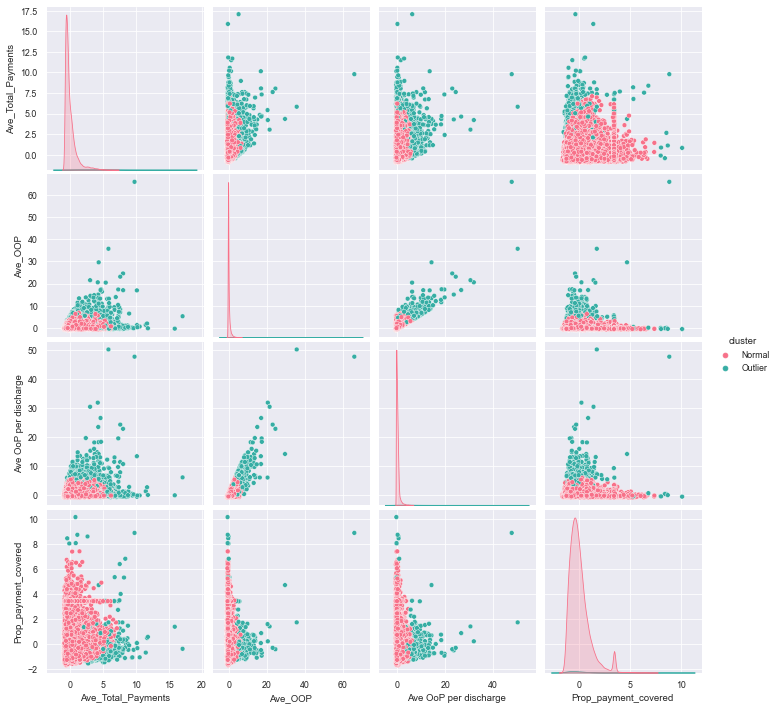

In [77]:
sns.pairplot(df_test.iloc[:,[1,2,3,4,9]], hue = 'cluster', palette='husl')

**Note**: From the summary statistic table above, the difference of the average anomaly score between the outlier cluster and the normal cluater is dramatically large (6 times difference). Additionally, the average values of other features also show big differences between them. 

#### Model 2:

In [78]:
clf2 = AutoEncoder(hidden_neurons =[9, 10,2, 10, 9])
clf2.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 81        
_________________________________________________________________
dropout_8 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

Epoch 57/100
3211/3211 [==============================] - 3s 980us/step - loss: 0.9980 - val_loss: 1.0179
Epoch 58/100
3211/3211 [==============================] - 3s 1ms/step - loss: 0.9980 - val_loss: 1.0179
Epoch 59/100
3211/3211 [==============================] - 3s 992us/step - loss: 0.9980 - val_loss: 1.0179
Epoch 60/100
3211/3211 [==============================] - 3s 1ms/step - loss: 0.9980 - val_loss: 1.0179
Epoch 61/100
3211/3211 [==============================] - 3s 1ms/step - loss: 0.9980 - val_loss: 1.0179
Epoch 62/100
3211/3211 [==============================] - 3s 987us/step - loss: 0.9980 - val_loss: 1.0179
Epoch 63/100
3211/3211 [==============================] - 3s 996us/step - loss: 0.9980 - val_loss: 1.0179
Epoch 64/100
3211/3211 [==============================] - 3s 991us/step - loss: 0.9980 - val_loss: 1.0179
Epoch 65/100
3211/3211 [==============================] - 3s 1ms/step - loss: 0.9980 - val_loss: 1.0179
Epoch 66/100
3211/3211 [==============================

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[9, 10, 2, 10, 9],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x000002632C152598>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

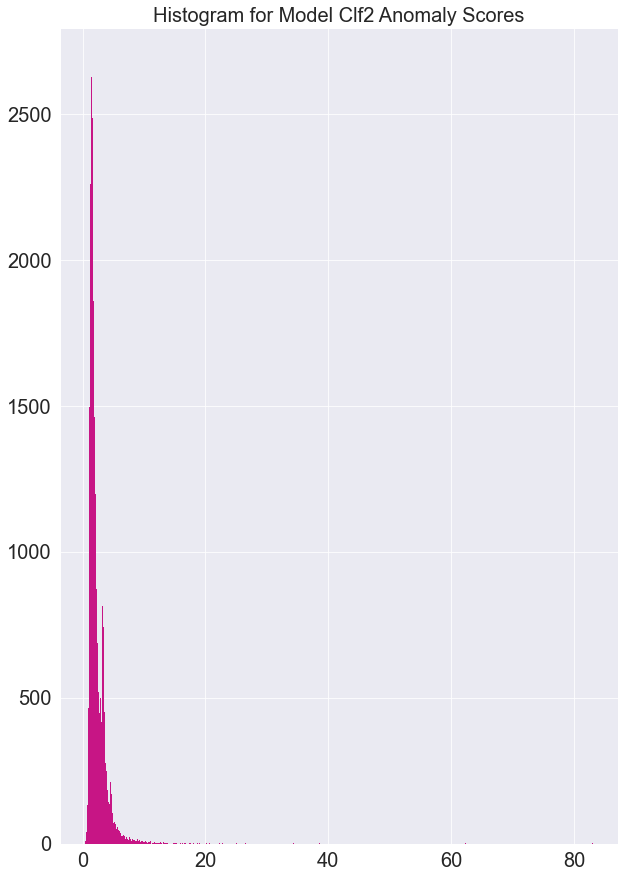

In [79]:
# Predict the anomaly scores
y_test_scores_2 = clf2.decision_function(X_test)  
y_test_scores_2 = pd.Series(y_test_scores_2)

# Plot the histogram
import matplotlib.pyplot as plt
plt.hist(y_test_scores_2, bins='auto', lw=0,  color='mediumvioletred')  
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.title("Histogram for Model Clf2 Anomaly Scores",fontsize = 20)
plt.show()

By using histogram to count the frequency by the anomaly score, it indicates that the higher the score is, the lower the frequency is, thus providing the group of outliers. As the chart shows that the frequency starts going down around 8 to 10, I choose 8 to be the cur point and >= 8 to be the outliers.

In [80]:
#Get the Summary Statistics by Cluster
df_test = X_test.copy()
old_col = df_test.columns[:9]
feature_name = features.columns
df_test.rename(columns=dict(zip(old_col, feature_name)), inplace=True)
df_test['score'] = y_test_scores_2
df_test['cluster'] = np.where(df_test['score']<8, 'Normal', 'Outlier')
df_test['cluster'].value_counts()

Normal     48378
Outlier      542
Name: cluster, dtype: int64

In [81]:
df_test.groupby('cluster').mean()

Ave_Covered_Charges  Ave_Total_Payments   Ave_OOP  \
cluster                                                      
Normal             -0.042881           -0.044647 -0.053812   
Outlier             3.827513            3.985085  4.803138   

         Ave OoP per discharge  Prop_payment_covered  Medicare_Coverage_Ratio  \
cluster                                                                         
Normal               -0.055129              0.000381                 0.010403   
Outlier               4.920745             -0.034044                -0.928540   

         Medicare_coverage_ratio_bystate  Mean_Ave_Covered_bystate      score  
cluster                                                                        
Normal                         -0.003704                 -0.006172   2.225198  
Outlier                         0.330630                  0.550895  11.504619

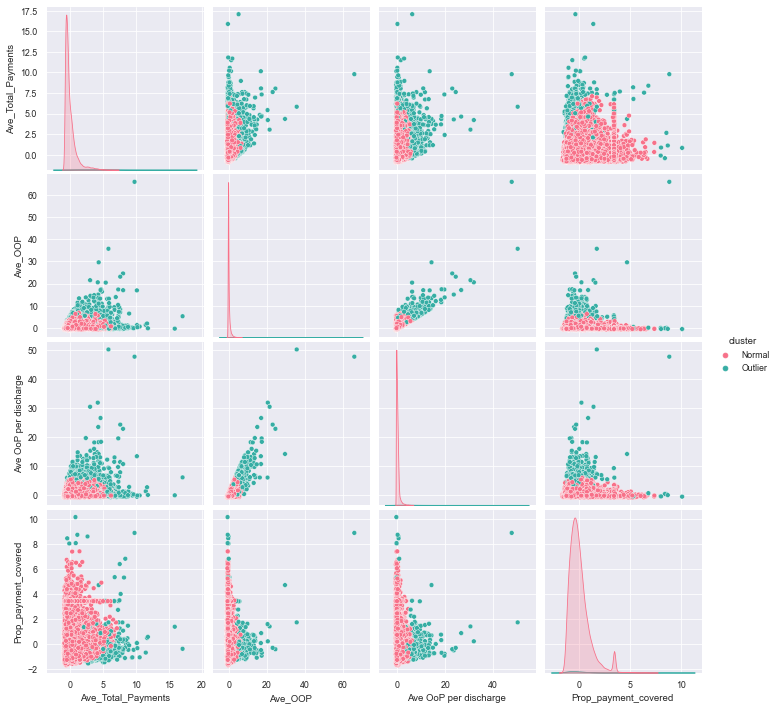

In [82]:
sns.pairplot(df_test.iloc[:,[1,2,3,4,9]], hue = 'cluster', palette='husl')

**Note**: The results in model 2 are similar like model 1. From the summary statistic table above, the difference of the average anomaly score between the outlier cluster and the normal cluater is dramatically large (6 times difference). Additionally, the average values of other features also show big differences between them. 

#### Model 3

In [83]:
# Step 1: Build the model
clf3 = AutoEncoder(hidden_neurons =[9, 15, 10, 2, 10,15,9])
clf3.fit(X_train)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_13 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_14 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 81        
_________________________________________________________________
dropout_15 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 15)               

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[9, 15, 10, 2, 10, 15, 9],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x000002632C152598>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

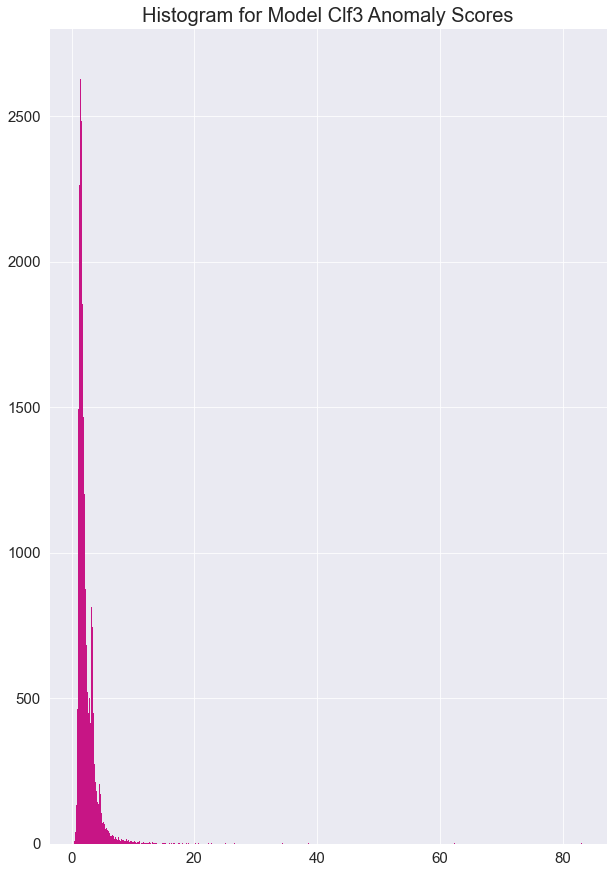

In [84]:
# Predict the anomaly scores
y_test_scores_3 = clf3.decision_function(X_test)  
y_test_scores_3 = pd.Series(y_test_scores_3)

# Step 2: Determine the cut point
import matplotlib.pyplot as plt
plt.hist(y_test_scores_3, bins='auto', lw=0,  color='mediumvioletred')  
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title("Histogram for Model Clf3 Anomaly Scores",fontsize = 20)
plt.show()

By using histogram to count the frequency by the anomaly score, it indicates that the higher the score is, the lower the frequency is, thus providing the group of outliers. As the chart shows that the frequency starts going down around 8 to 10, I choose 8 to be the cur point and >= 8 to be the outliers. 

In [85]:
#Get the Summary Statistics by Cluster
df_test = X_test.copy()
old_col = df_test.columns[:9]
feature_name = features.columns
df_test.rename(columns=dict(zip(old_col, feature_name)), inplace=True)
df_test['score'] = y_test_scores_3
df_test['cluster'] = np.where(df_test['score']<8, 'Normal', 'Outlier')
df_test['cluster'].value_counts()

Normal     48378
Outlier      542
Name: cluster, dtype: int64

In [86]:
df_test.groupby('cluster').mean()

Ave_Covered_Charges  Ave_Total_Payments   Ave_OOP  \
cluster                                                      
Normal             -0.042881           -0.044647 -0.053812   
Outlier             3.827513            3.985085  4.803138   

         Ave OoP per discharge  Prop_payment_covered  Medicare_Coverage_Ratio  \
cluster                                                                         
Normal               -0.055129              0.000381                 0.010403   
Outlier               4.920745             -0.034044                -0.928540   

         Medicare_coverage_ratio_bystate  Mean_Ave_Covered_bystate      score  
cluster                                                                        
Normal                         -0.003704                 -0.006172   2.225281  
Outlier                         0.330630                  0.550895  11.504405

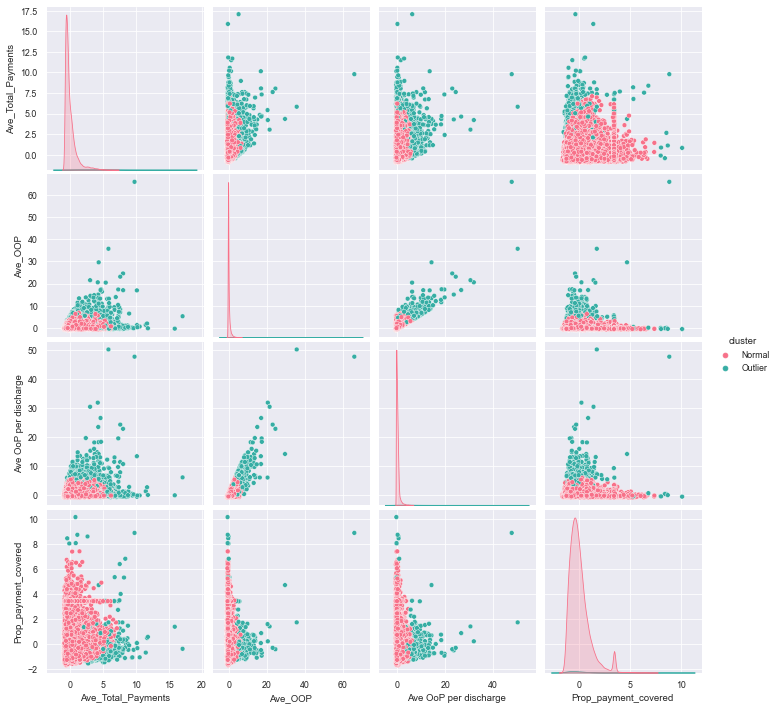

In [87]:
sns.pairplot(df_test.iloc[:,[1,2,3,4,9]], hue = 'cluster', palette='husl')

**Note**: The results in model 3 are similar to model 1 and model 2, including the number of outliers and the summary statistic table. From the summary statistic table above, the difference of the average anomaly score between the outlier cluster and the normal cluater is dramatically large (6 times difference). Additionally, the average values of other features also show big differences between them. 

#### Aggregate to Achieve Model Stability

Although unsupervised techniques are powerful in detecting outliers, they are prone to overfitting and unstable results. The solution is to train multiple models then aggregate the scores

In [88]:
%%capture --no-stdout --no-display output 
#Stop warning from showing
# Put all the predictions in a data frame
from pyod.models.combination import aom, moa, average, maximization

# Put all the predictions in a data frame
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test) 
                            })

In [89]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

In [90]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

##### Average Method

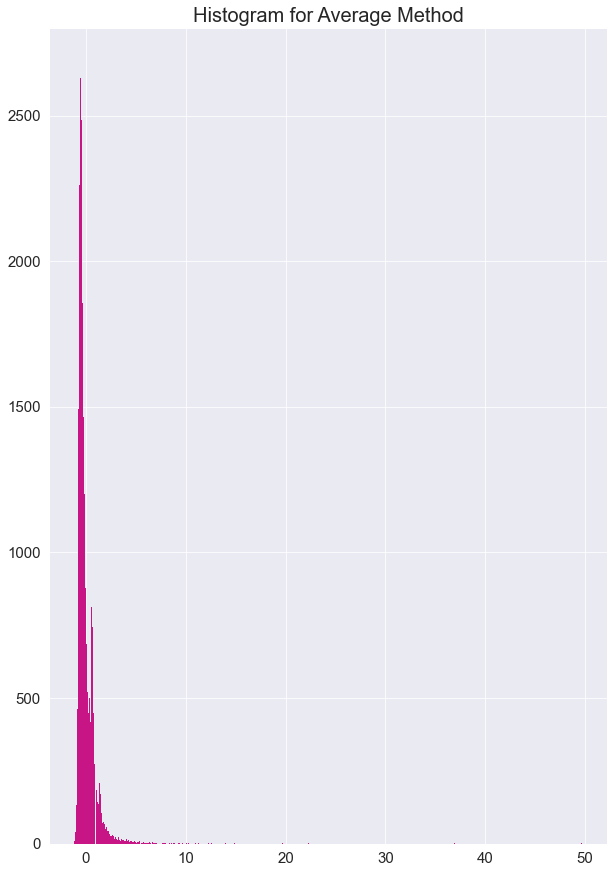

In [91]:
# Combination by average
y_by_average = average(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto', lw=0,  color='mediumvioletred')  
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title("Histogram for Average Method",fontsize = 20)
plt.show()

By using histogram to count the frequency by the anomaly score, it indicates that the higher the score is, the lower the frequency is, thus providing the group of outliers. As the chart shows that the fequency starts going down somewhere below 5, I choose 2 to be the cur point and >= 2 to be the outliers. 

In [92]:
df_test = X_test.copy()
old_col = df_test.columns[:9]
feature_name = features.columns
df_test.rename(columns=dict(zip(old_col, feature_name)), inplace=True)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<2,'Normal', 'Outlier')
df_test['y_by_average_cluster'].value_counts()

Normal     47460
Outlier     1460
Name: y_by_average_cluster, dtype: int64

In [93]:
df_test.groupby('y_by_average_cluster').mean()

Ave_Covered_Charges  Ave_Total_Payments   Ave_OOP  \
y_by_average_cluster                                                      
Normal                          -0.087677           -0.096259 -0.091224   
Outlier                          2.850087            3.129089  2.965398   

                      Ave OoP per discharge  Prop_payment_covered  \
y_by_average_cluster                                                
Normal                            -0.087021             -0.003402   
Outlier                            2.828771              0.110586   

                      Medicare_Coverage_Ratio  \
y_by_average_cluster                            
Normal                               0.014987   
Outlier                             -0.487177   

                      Medicare_coverage_ratio_bystate  \
y_by_average_cluster                                    
Normal                                      -0.010536   
Outlier                                      0.342501   

                      Mean_Ave_Covered_bystate  y_by_average_score  
y_by_average_cluster                                                
Normal                               -0.013194           -0.106002  
Outlier                               0.428905            3.724213

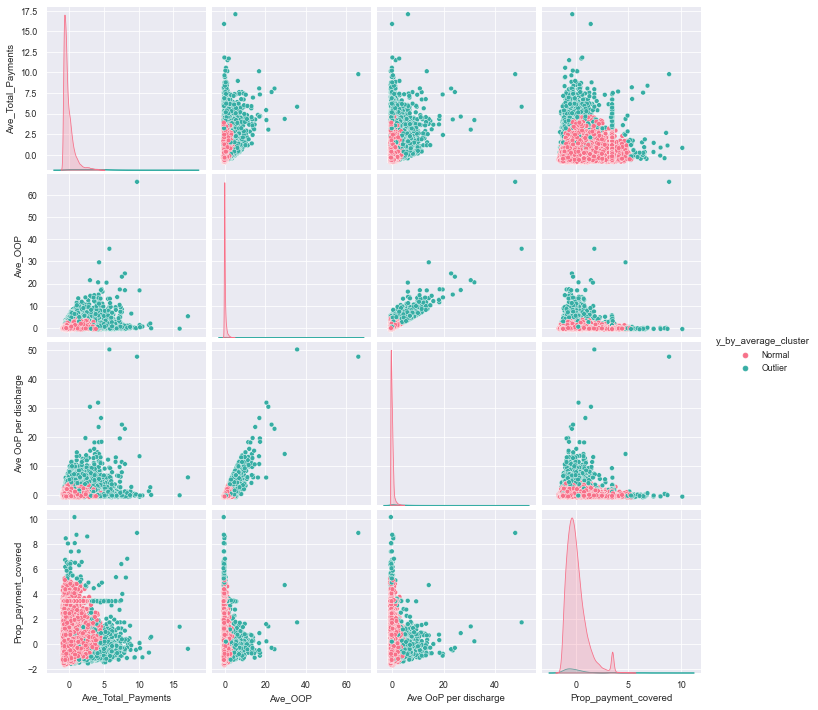

In [94]:
sns.pairplot(df_test.iloc[:,[1,2,3,4,9]], hue = 'y_by_average_cluster', palette='husl')

**Note**: From the summary statistic table above, the difference of the average anomaly score between the outlier cluster and the normal cluater is high (3.8 compare to -0.12). Additionally, the average values of other features also show big differences between them. This indicates that the data points in the outlier cluster is anomolous and need to be investigated.

#### Maximum of Maximum Method

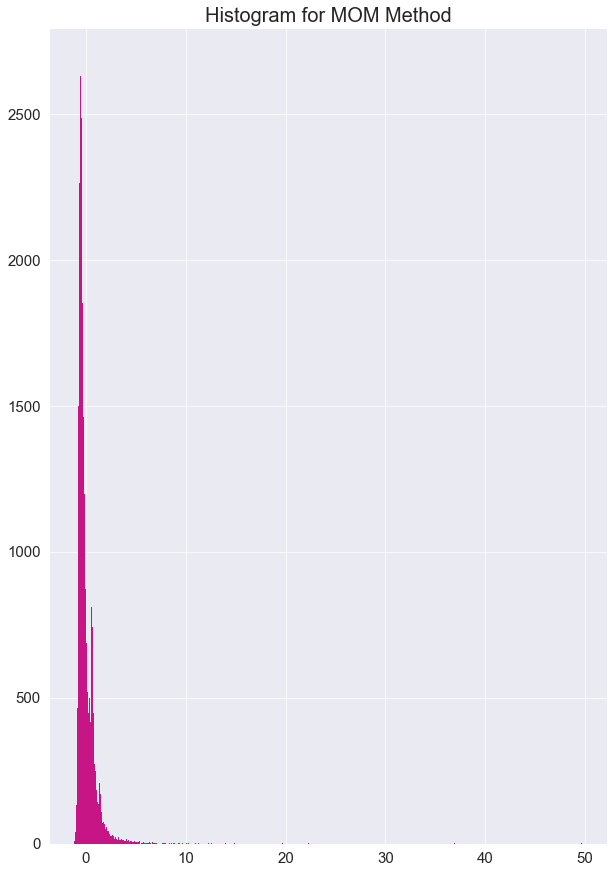

In [95]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto', lw=0,  color='mediumvioletred')  
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title("Histogram for MOM Method",fontsize = 20)
plt.show()

By using histogram to count the frequency by the anomaly score, it indicates that the higher the score is, the lower the frequency is, thus providing the group of outliers. As the chart shows that the fequency starts going down somewhere below 5, I choose 3 to be the cur point and >= 3 to be the outliers. 

In [96]:
df_test = X_test.copy()
old_col = df_test.columns[:9]
feature_name = features.columns
df_test.rename(columns=dict(zip(old_col, feature_name)), inplace=True)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<3, 'Normal', 'Outlier')
df_test['y_by_maximization_cluster'].value_counts()

Normal     48181
Outlier      739
Name: y_by_maximization_cluster, dtype: int64

In [97]:
df_test.groupby('y_by_maximization_cluster').mean()

Ave_Covered_Charges  Ave_Total_Payments   Ave_OOP  \
y_by_maximization_cluster                                                      
Normal                               -0.054218           -0.057347 -0.064919   
Outlier                               3.534876            3.738857  4.232565   

                           Ave OoP per discharge  Prop_payment_covered  \
y_by_maximization_cluster                                                
Normal                                 -0.064573              0.000395   
Outlier                                 4.209992             -0.025736   

                           Medicare_Coverage_Ratio  \
y_by_maximization_cluster                            
Normal                                    0.012656   
Outlier                                  -0.825148   

                           Medicare_coverage_ratio_bystate  \
y_by_maximization_cluster                                    
Normal                                           -0.004994   
Outlier                                           0.325596   

                           Mean_Ave_Covered_bystate  y_by_maximization_score  
y_by_maximization_cluster                                                     
Normal                                    -0.007799                -0.068231  
Outlier                                    0.508460                 5.010593

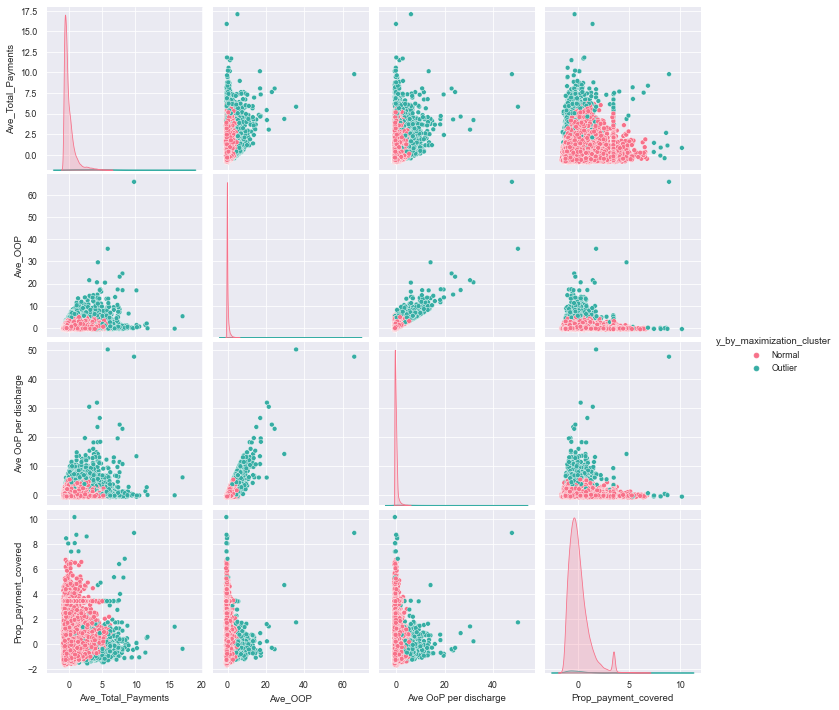

In [98]:
sns.pairplot(df_test.iloc[:,[1,2,3,4,9]], hue = 'y_by_maximization_cluster', palette='husl')

**Note**: The result of MOM is similar to the average method. From the summary statistic table above, the difference of the average anomaly score between the outlier cluster and the normal cluater is high (3.8 compare to -0.12). Additionally, the average values of other features also show big differences between them. This indicates that the data points in the outlier cluster is anomolous and need to be investigated.

### Isolation Forest

Isolation algorithm is useful for both supervised and unsupervised learning. Isolation Forest is an unsupervised learning that calculates an anomaly score and seperates into binary based on an anomaly threshhold. The way that the algorithm constructs the separation is by first creating isolation trees or random decision trees. Then, the score is calculated as the path length to isolate the observation. Isolation forest randomly choose split points among ranomly choosen variables which help to reduce the chance of overfitting. 

Isolation forest is an advanced outlier dection that delects anomalies based on the concept of isolation instead of distance or density measurment. It is different from other methods like KNN or PCA in anomalies dectection and is knowns as an effective method at reducing frauds.

#### Model 1: {Samples: Auto}

In [99]:
from pyod.models.iforest import IForest
clf1 = IForest(behaviour="new", bootstrap=True,n_jobs=-1,) 
clf1.fit(X_train)

IForest(behaviour='new', bootstrap=True, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=-1, random_state=None,
    verbose=0)

In [100]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores_1 = clf1.decision_function(X_test)  # outlier scores
y_test_scores_1 = pd.Series(y_test_scores_1)

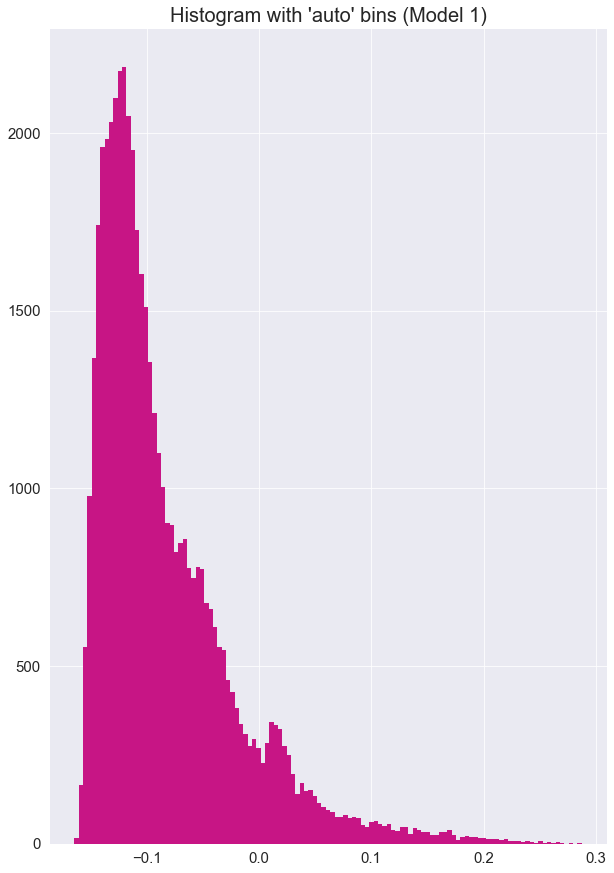

In [101]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores_1, bins='auto', lw=0,  color='mediumvioletred')  
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title("Histogram with 'auto' bins (Model 1)",fontsize = 20)
plt.show()

By using histogram to count the frequency by the anomaly score, it indicates that the higher the score is, the lower the frequency is, thus providing the group of outliers. As the chart shows that the fequency starts going down around 0.1, I choose 0.1 to be the cur point and >= 0.1 to be the outliers. 

In [102]:
df_test = X_test.copy()
old_col = df_test.columns[:9]
feature_name = features.columns
df_test.rename(columns=dict(zip(old_col, feature_name)), inplace=True)
df_test['score'] = y_test_scores_1
df_test['cluster'] = np.where(df_test['score']<0.15, 'Normal', 'Outlier')
df_test['cluster'].value_counts()

Normal     48493
Outlier      427
Name: cluster, dtype: int64

In [103]:
df_test.groupby('cluster').mean()

Ave_Covered_Charges  Ave_Total_Payments   Ave_OOP  \
cluster                                                      
Normal             -0.026142           -0.031459 -0.054863   
Outlier             2.968895            3.572701  6.230646   

         Ave OoP per discharge  Prop_payment_covered  Medicare_Coverage_Ratio  \
cluster                                                                         
Normal               -0.053461             -0.000656                 0.014086   
Outlier               6.071338              0.074541                -1.599683   

         Medicare_coverage_ratio_bystate  Mean_Ave_Covered_bystate     score  
cluster                                                                       
Normal                         -0.002030                 -0.003021 -0.085794  
Outlier                         0.230486                  0.343133  0.188436

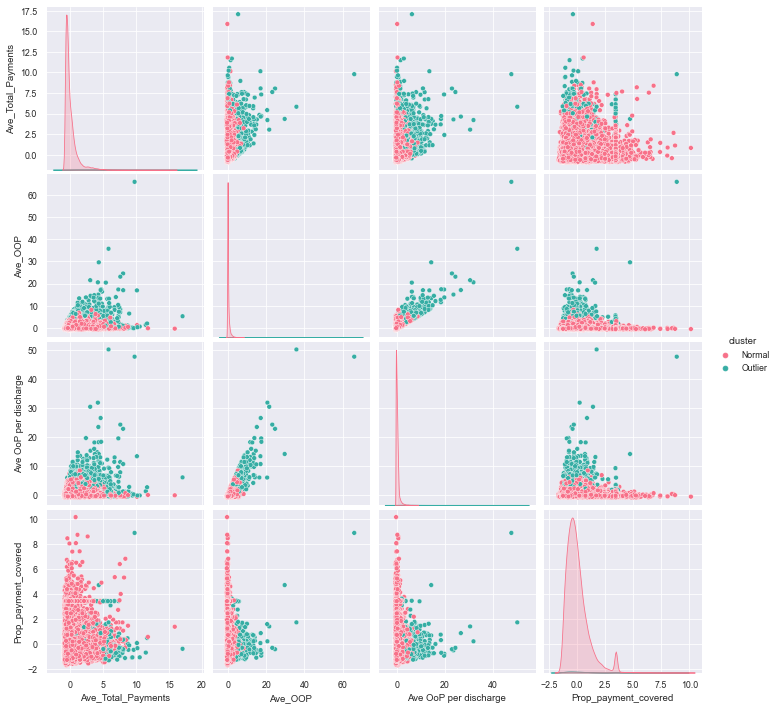

In [104]:
sns.pairplot(df_test.iloc[:,[1,2,3,4,9]], hue = 'cluster', palette='husl')

**Note**: From the summary statistic table above, the difference of the average anomaly score between the outlier cluster and the normal cluater is high. Additionally, the average values of other features also show big differences between them. This indicates that the data points in the outlier cluster is anomolous and need to be investigated.

#### Model 2: Samples: 50

In [105]:
clf2 = IForest(max_samples=50, bootstrap=True,n_jobs=-1,) 
clf2.fit(X_train)

IForest(behaviour='old', bootstrap=True, contamination=0.1, max_features=1.0,
    max_samples=50, n_estimators=100, n_jobs=-1, random_state=None,
    verbose=0)

In [106]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores_2 = clf2.decision_function(X_test)  # outlier scores
y_test_scores_2 = pd.Series(y_test_scores_2)
y_test_scores_2.head()

0   -0.120533
1   -0.059649
2   -0.077699
3   -0.090892
4   -0.146159
dtype: float64

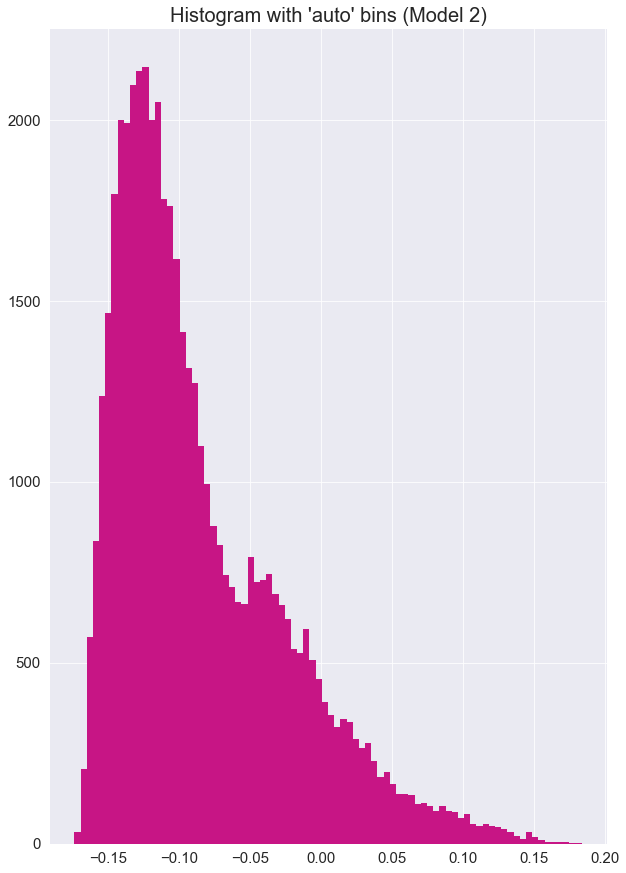

In [107]:
plt.hist(y_test_scores_2, bins='auto', lw=0,  color='mediumvioletred')  
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title("Histogram with 'auto' bins (Model 2)",fontsize = 20)
plt.show()

By using histogram to count the frequency by the anomaly score, it indicates that the higher the score is, the lower the frequency is, thus providing the group of outliers. As the chart shows that the fequency starts going down around 0.1, I choose 0.1 to be the cur point and >= 0.1 to be the outliers. 

In [108]:
df_test = X_test.copy()
old_col = df_test.columns[:9]
feature_name = features.columns
df_test.rename(columns=dict(zip(old_col, feature_name)), inplace=True)
df_test['score'] = y_test_scores_2
df_test['cluster'] = np.where(df_test['score']<0.1, 'Normal', 'Outlier')
df_test['cluster'].value_counts()

Normal     48393
Outlier      527
Name: cluster, dtype: int64

In [109]:
df_test.groupby('cluster').mean()

Ave_Covered_Charges  Ave_Total_Payments   Ave_OOP  \
cluster                                                      
Normal             -0.036478           -0.039582 -0.058009   
Outlier             3.349670            3.634723  5.326820   

         Ave OoP per discharge  Prop_payment_covered  Medicare_Coverage_Ratio  \
cluster                                                                         
Normal               -0.053923              0.001716                 0.010206   
Outlier               4.951623             -0.157540                -0.937174   

         Medicare_coverage_ratio_bystate  Mean_Ave_Covered_bystate     score  
cluster                                                                       
Normal                         -0.004756                 -0.006885 -0.086998  
Outlier                         0.436728                  0.632238  0.122749

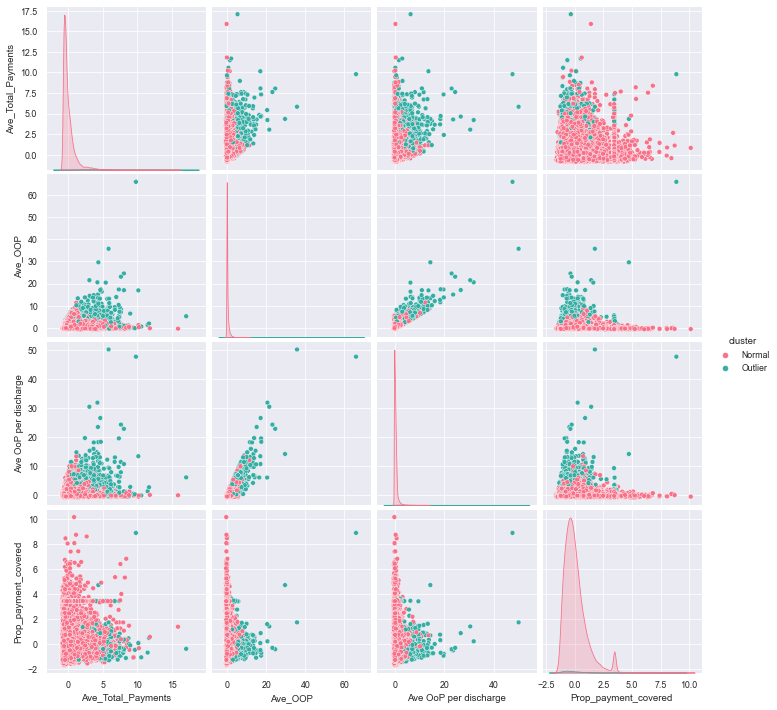

In [110]:
sns.pairplot(df_test.iloc[:,[1,2,3,4,9]], hue = 'cluster', palette='husl')

**Note**: The results in model 2 are similar to model 1. From the summary statistic table above, the difference of the average anomaly score between the outlier cluster and the normal cluater is high. Additionally, the average values of other features also show big differences between them. This indicates that the data points in the outlier cluster is anomolous and need to be investigated.

#### Model 3: Sample: 100

In [111]:
clf3 = IForest(behaviour="new", max_samples=100, bootstrap=True,n_jobs=-1,) 
clf3.fit(X_train)

IForest(behaviour='new', bootstrap=True, contamination=0.1, max_features=1.0,
    max_samples=100, n_estimators=100, n_jobs=-1, random_state=None,
    verbose=0)

In [112]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores_3 = clf3.decision_function(X_test)  # outlier scores
y_test_scores_3 = pd.Series(y_test_scores_3)
y_test_scores_3.head()

0   -0.138078
1   -0.079561
2   -0.091734
3   -0.072862
4   -0.152575
dtype: float64

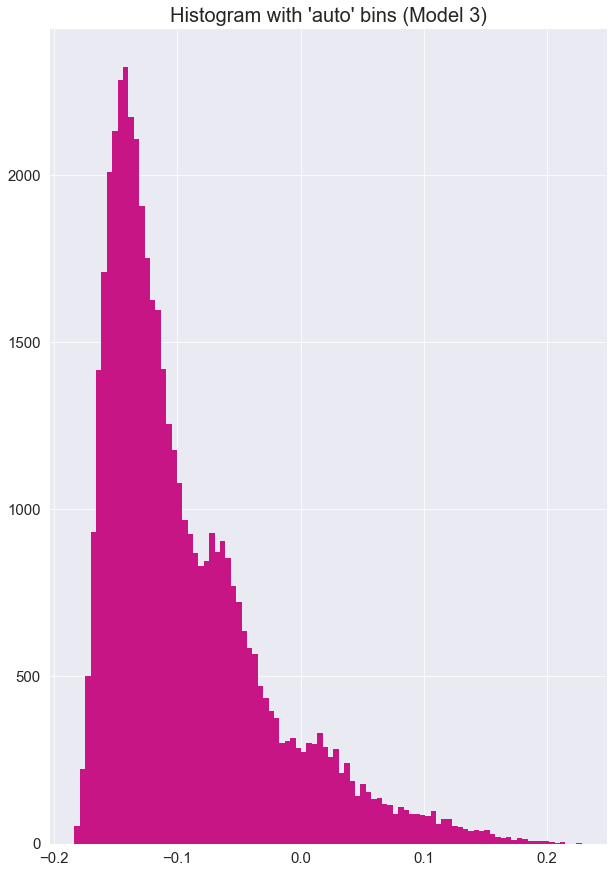

In [113]:
plt.hist(y_test_scores_3, bins='auto', lw=0,  color='mediumvioletred')  
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title("Histogram with 'auto' bins (Model 3)",fontsize = 20)
plt.show()

By using histogram to count the frequency by the anomaly score, it indicates that the higher the score is, the lower the frequency is, thus providing the group of outliers. As the chart shows that the fequency starts going down around 0.1, I choose 0.1 to be the cur point and >= 0.1 to be the outliers. 

In [114]:
df_test = X_test.copy()
old_col = df_test.columns[:9]
feature_name = features.columns
df_test.rename(columns=dict(zip(old_col, feature_name)), inplace=True)
df_test['score'] = y_test_scores_3
df_test['cluster'] = np.where(df_test['score']<0.1, 'Normal', 'Outlier')
df_test['cluster'].value_counts()

Normal     48056
Outlier      864
Name: cluster, dtype: int64

In [115]:
df_test.groupby('cluster').mean()

Ave_Covered_Charges  Ave_Total_Payments   Ave_OOP  \
cluster                                                      
Normal             -0.052835           -0.059139 -0.077434   
Outlier             2.938695            3.289350  4.306935   

         Ave OoP per discharge  Prop_payment_covered  Medicare_Coverage_Ratio  \
cluster                                                                         
Normal                -0.07491             -0.000069                 0.016678   
Outlier                4.16652              0.003846                -0.927660   

         Medicare_coverage_ratio_bystate  Mean_Ave_Covered_bystate     score  
cluster                                                                       
Normal                         -0.007143                 -0.009232 -0.097827  
Outlier                         0.397287                  0.513484  0.131902

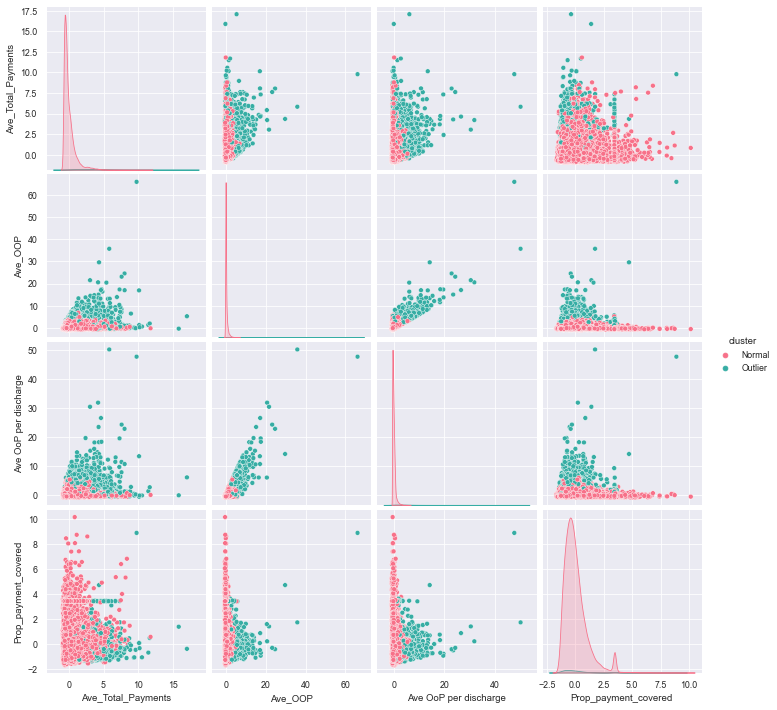

In [116]:
sns.pairplot(df_test.iloc[:,[1,2,3,4,9]], hue = 'cluster', palette='husl')

**Note**: The results in model 3 are similar to model 1 and model 2. From the summary statistic table above, the difference of the average anomaly score between the outlier cluster and the normal cluater is high. Additionally, the average values of other features also show big differences between them. This indicates that the data points in the outlier cluster is anomolous and need to be investigated.

#### Aggregate to Achieve Model Stability

In [117]:
# The predictions of the training data can be obtained by clf.decision_scores_.
# It is already generated during the model building process.
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test) 
                            })

In [118]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

#### Average Method

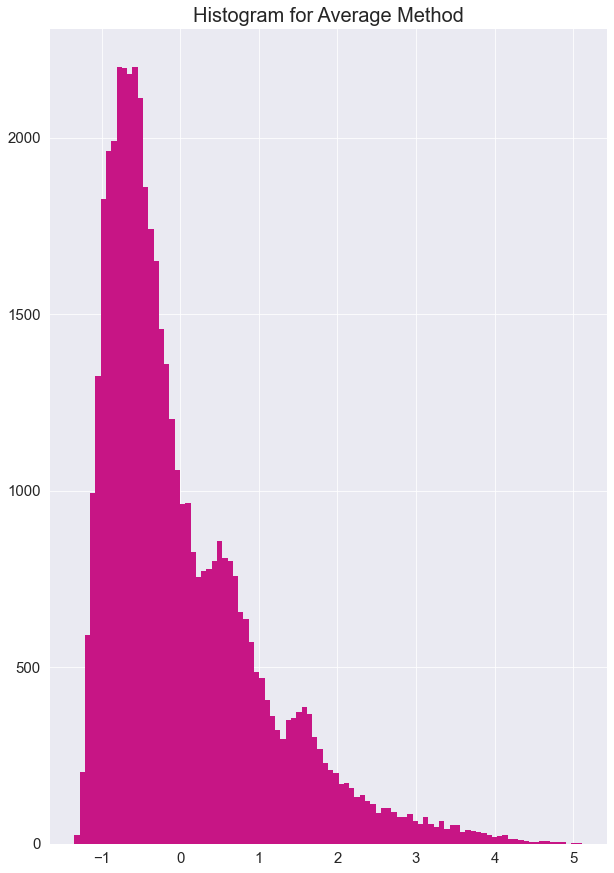

In [119]:
# Combination by average
y_by_average = average(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto', lw=0,  color='mediumvioletred')  
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title("Histogram for Average Method",fontsize = 20)
plt.show()

By using histogram to count the frequency by the anomaly score, it indicates that the higher the score is, the lower the frequency is, thus providing the group of outliers. As the chart shows that the fequency starts going down around 3, I choose 3 to be the cur point and >= 3 to be the outliers. 

In [120]:
df_test = X_test.copy()
old_col = df_test.columns[:9]
feature_name = features.columns
df_test.rename(columns=dict(zip(old_col, feature_name)), inplace=True)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<3,'Normal', 'Outlier')
df_test['y_by_average_cluster'].value_counts()

Normal     48116
Outlier      804
Name: y_by_average_cluster, dtype: int64

In [121]:
df_test.groupby('y_by_average_cluster').mean()

Ave_Covered_Charges  Ave_Total_Payments   Ave_OOP  \
y_by_average_cluster                                                      
Normal                          -0.049303           -0.055297 -0.075570   
Outlier                          2.950552            3.309267  4.522553   

                      Ave OoP per discharge  Prop_payment_covered  \
y_by_average_cluster                                                
Normal                            -0.072741              0.000168   
Outlier                            4.353235             -0.010076   

                      Medicare_Coverage_Ratio  \
y_by_average_cluster                            
Normal                               0.017258   
Outlier                             -1.032837   

                      Medicare_coverage_ratio_bystate  \
y_by_average_cluster                                    
Normal                                      -0.006548   
Outlier                                      0.391848   

                      Mean_Ave_Covered_bystate  y_by_average_score  
y_by_average_cluster                                                
Normal                               -0.008200           -0.043871  
Outlier                               0.490754            3.564904

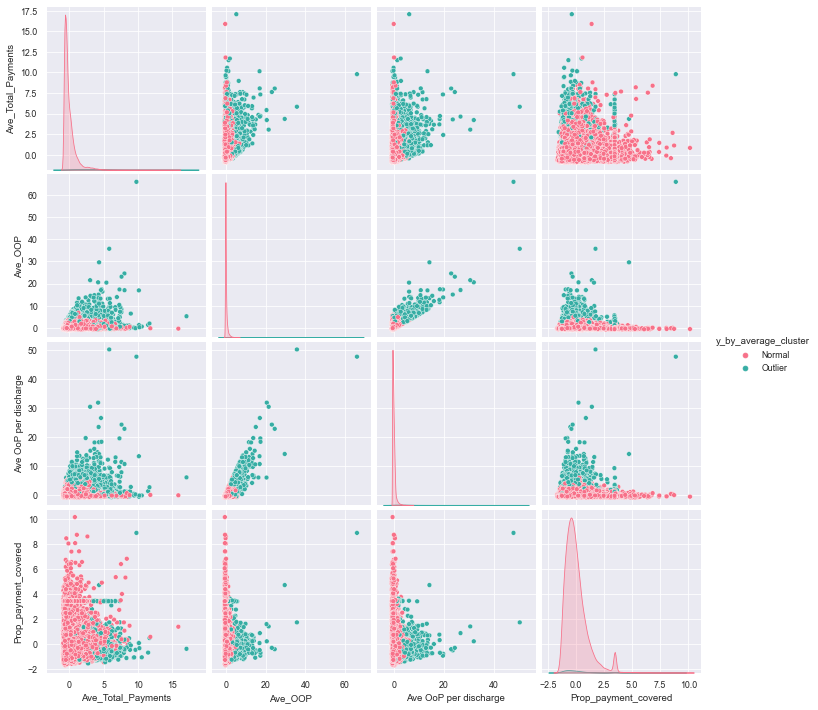

In [122]:
sns.pairplot(df_test.iloc[:,[1,2,3,4,9]], hue = 'y_by_average_cluster', palette='husl')

**Note**: From the summary statistic table above, the difference of the average anomaly score between the outlier cluster and the normal cluater is high. Additionally, the average values of other features also show big differences between them. This indicates that the data points in the outlier cluster is anomolous and need to be investigated.

#### Maximum of maximum method

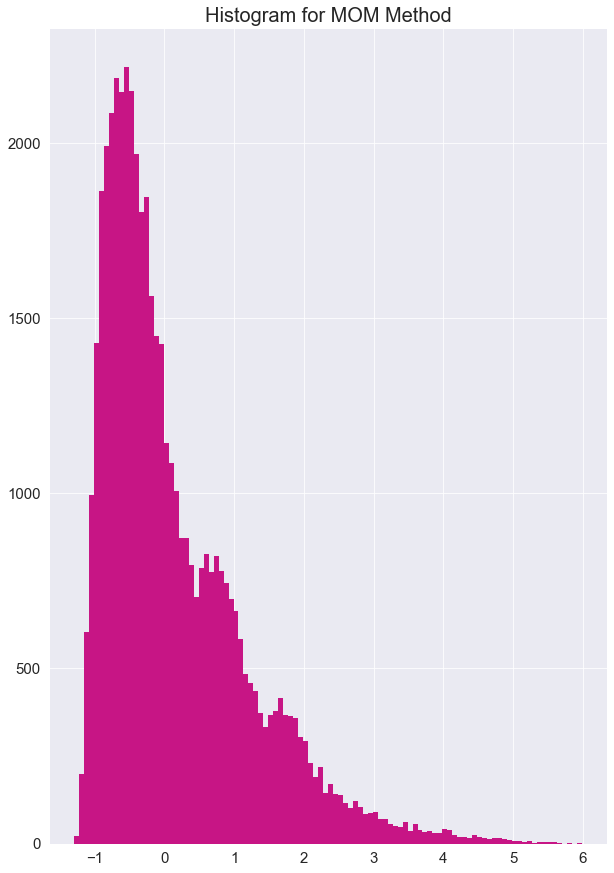

In [123]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto', lw=0,  color='mediumvioletred')  
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title("Histogram for MOM Method",fontsize = 20)
plt.show()

By using histogram to count the frequency by the anomaly score, it indicates that the higher the score is, the lower the frequency is, thus providing the group of outliers. As the chart shows that the fequency starts going down around 3, I choose 3 to be the cur point and >= 3 to be the outliers. 

In [124]:
df_test = X_test.copy()
old_col = df_test.columns[:9]
feature_name = features.columns
df_test.rename(columns=dict(zip(old_col, feature_name)), inplace=True)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<3,'Normal', 'Outlier')
df_test['y_by_maximization_cluster'].value_counts()

Normal     47889
Outlier     1031
Name: y_by_maximization_cluster, dtype: int64

In [125]:
df_test.groupby('y_by_maximization_cluster').mean()

Ave_Covered_Charges  Ave_Total_Payments   Ave_OOP  \
y_by_maximization_cluster                                                      
Normal                               -0.059620           -0.068439 -0.085933   
Outlier                               2.769287            3.178911  3.991489   

                           Ave OoP per discharge  Prop_payment_covered  \
y_by_maximization_cluster                                                
Normal                                 -0.081852             -0.001153   
Outlier                                 3.801928              0.053541   

                           Medicare_Coverage_Ratio  \
y_by_maximization_cluster                            
Normal                                    0.021232   
Outlier                                  -0.986216   

                           Medicare_coverage_ratio_bystate  \
y_by_maximization_cluster                                    
Normal                                           -0.007112   
Outlier                                           0.330359   

                           Mean_Ave_Covered_bystate  y_by_maximization_score  
y_by_maximization_cluster                                                     
Normal                                    -0.008843                 0.070621  
Outlier                                    0.410750                 3.771988

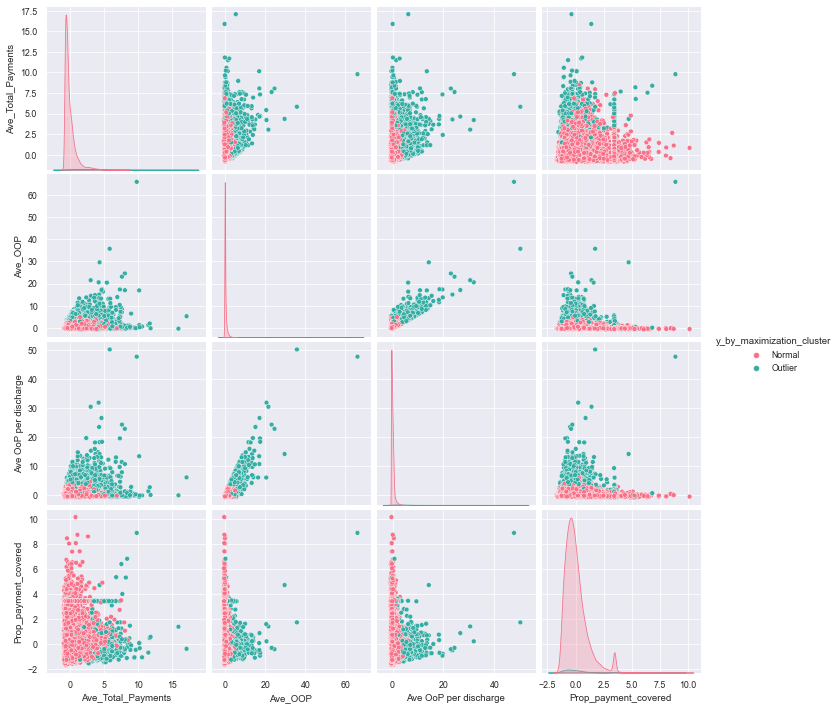

In [126]:
sns.pairplot(df_test.iloc[:,[1,2,3,4,9]], hue = 'y_by_maximization_cluster', palette='husl')

**Note**: The results of MOM method is similar to the results in the average method. From the summary statistic table above, the difference of the average anomaly score between the outlier cluster and the normal cluater is high. Additionally, the average values of other features also show big differences between them. This indicates that the data points in the outlier cluster is anomolous and need to be investigated.

### Conclusion:

After trying both autoencoder and isolation techniques, I think combining different approaches/method and comparing results increases prediction confidence, and reduce bias. From that, I believe it creates a higher level of confidence, especially since each parameter selection contains bias. As the resulls come out similar within each algorithm, my takeaways would be investigating the accounts that are defined as outliers in the techniques utilized.  